This notebook best viewed here: https://nbviewer.jupyter.org

<a id='home'></a>

This notebook is for the coastal variety of Douglas fir GEA mapping pops

1. [Choose SNPs for GEA structure correction in baypass](#choose)
    1. [load snps and filter for depth](#depth)
        - filter for 20≤depth<1000.
    1. [reduce SNPs to those on contigs ≥ 1Kbp](#contig)
    1. [try and filter for no missing data](#missing)
        - I tried this, but I can't filter for no missing data, the MAF spectrum doesn't match well with MAF spectrum of all data, so filters for nomissing data was not implemented
    1. [choose one snp per contig at random](#random)
    1. [determine threshold for LD pruning](#r2thresh)
        - an r2thresh of 0.3578. Using a threshold below this value resulted in non-converging covariance matrix estimation across replicates. This threshold corresponded roughly to the 99.5th percentile of the distribution of LD values.
    1. [LD prune random loci](#prune)
    
1. [create infiles to baypass to estimate neutral structure](#infiles)
    1. [genotype file](#genotyping)
    1. [poolsizefile](#poolsizefile)

1. [create 5 replicate estimates of the covariance matrix](#covariance)
    1. [make and rsync shfiles for cedar HPC server](#shfiles)
        - bash shfiles were submitted to slurm for execution

1. [look at covariance matrices output from chains](#look)
    1. [rsync the files from cedar HPC](#rersync)
    1. [read in matrices and look at convergence](#readin)
        - matrices were highly correlated (r > 0.972)
    1. [estimate average covariance matrix](#avg)
    1. [compare avg matrix to replicate matrices](#compare)
        - the avg matrix was highly correlated with each of the replicate matrices (r > 0.989)

1. [create infiles to baypass for GEA](#geainfiles)
    1. [environmental file](#efile)
    1. [genotype file](#gfile)
        1. [break up genotype file for parallelization](#gparallel)

1. [create commands to run baypass GEA using gfiles from above](#commands)
    1. [create catfiles to hold commands](#catfiles)
    1. [create slurm shfiles for executing commands in parallel](#geashfiles)
    1. [transfer to cedar, graham, beluga, and arc](#transfer)
        - bash shfiles were submitted to slurm for execution

In [1]:
from pythonimports import *

DIR = '/data/projects/pool_seq/DF_datasets'
snpdir = op.join(DIR, 'DF_pooled_GEA/DF_pooled/snpsANDindels/coastal_variety_with-p6/03_maf-p05_RD-recalculated_FDC')
assert op.exists(snpdir)
baydir = makedir(op.join(snpdir, 'baypass'))
op.exists(baydir)

True

In [2]:
latest_commit()

##################################################################
Current commit of pythonimports:
commit 4937ed6baded6e6e058c905e26e9ae16bfe3f0d9
Author: Brandon <lindb@vcu.edu>
Date:   Tue Dec 1 11:28:39 2020 -0700
Today:	December 14, 2020 - 16:58:36
##################################################################



<a id='choose'></a>
# Choose SNPs for GEA structure correction in baypass


[top](#home)

In [3]:
# get parallel engines
lview,dview = get_client()

56 56


<a id='depth'></a>
#### load snps and filter for depth

In [2]:
def get_counts(loci, numpops=0):
    """Create gfile for baypass.
    
    Get read counts for global major and minor allele. Missing data = 0."""
    import pandas
    from collections import OrderedDict
    import tqdm
    
    pops = [col.replace(".FREQ","") for col in reduced.columns if '.FREQ' in col]
    assert len(pops) == numpops
    read_counts = OrderedDict()
    for locus in tqdm.tqdm(loci):
        if reduced.loc[locus, 'AF'] > 0.5:
            refismajor = False
            majortag = 'AD'
            minortag = 'RD'
        else:
            refismajor = True
            majortag = 'RD'
            minortag = 'AD'
        if refismajor is True:
#             print('checking ', locus)
            # double check that it matches MAF calculation
            assert reduced.loc[locus, 'AF'] == reduced.loc[locus, 'MAF']
        for pop in pops:
            for which,tag in zip(['major','minor'],[majortag, minortag]):
                newcol = "%s-%s" % (pop,which)
                if newcol not in read_counts:
                    read_counts[newcol] = OrderedDict()
                if reduced.loc[locus, f"{pop}.FREQ"] != reduced.loc[locus, f"{pop}.FREQ"]:
                    # if locus was filtered for this pop
                    read_counts[newcol][locus] = 0
                else:
                    try:
                        read_counts[newcol][locus] = int(reduced.loc[locus, "%s.%s" % (pop, tag)])
                    except ValueError as e:
                        # missing data - probably don't need this try statement when first looking at FREQ
                        read_counts[newcol][locus] = 0
    return pandas.DataFrame(read_counts)

In [4]:
# figure making functions
def get_mafdict(afs, roundto):
    # bins for p52 depth
    mafs = [round(1-float(af),roundto) if float(af) > 0.5 else round(float(af),roundto) for af in afs]
    t = table(mafs)
    mafsdict = OrderedDict()
    for k in sorted(t):
        newk = '%.10f' % k
        if not newk in mafsdict:
            mafsdict[newk] = t[k]
        else:
            mafsdict[newk] += t[k]
    retdict = OrderedDict()
    for newk,count in mafsdict.items():
        retdict[newk] = count / sum(mafsdict.values())
    print(len(retdict.keys()))

    return retdict

def subcategorybar(X, vals, width=.9):
    n = len(vals)
    _X = np.arange(len(X))
    for i in range(n):
        plt.bar(_X - width/2. + i/float(n)*width, vals[i], 
                width=width/float(n), align="edge")   
    plt.xticks(_X, X)

def make_mafdict_fig(pruned_snpdict, all_snpdict, title=None):
    fig = plt.figure(figsize=(25,5))
    X = ['%.3f' % float(key) for key in sorted(keys(pruned_snpdict))]
    Y = [pruned_snpdict[freq] for freq in sorted(keys(pruned_snpdict))]
    Z = [all_snpdict[freq] for freq in sorted(keys(all_snpdict))]
    subcategorybar(X, [Y,Z])
    plt.legend(['filtered snps', 'all snps'],fontsize=20)
    plt.ylabel('proportion of SNPs in category',size=20)
    plt.xlabel('minor allele frequency',size=20)
    plt.title(title, size=20)
    plt.show()

    
# filtering functions
def filter_depth(chunk):
    """Filter min/max depth, reduce columns."""
    dpcols = [col for col in chunk.columns if '.DP' in col]
    freqcols = [col for col in chunk.columns if '.FREQ' in col]
    cols = ['CHROM', 'locus', 'AF', 'MAF'] + dpcols + freqcols
    chunk = chunk[cols].copy()
    for col in dpcols:
        chunk = chunk[chunk[col] >= 20].copy()
        chunk = chunk[chunk[col] < 1000].copy()
    chunk.index = chunk['locus'].tolist()
    return chunk

In [5]:
# filter for min depth > 20 and max depth < 1000
f = op.join(snpdir, 'DF_pooled-varscan_all_bedfiles_SNP_FDC_maf_RD-recalculated.txt')
snps = parallel_read(f,
                     lview=lview, dview=dview,
                     verbose=False,
                     assert_rowcount=False,
                     **dict(functions=create_fundict(filter_depth)))
print(snps.shape)
snps.index = snps['locus'].tolist()
snps.head()


Watching 56 parallel_read() jobs ...


DF_pooled-varscan_all_bedfiles_SNP_FDC_maf_RD-recalculated.txt: 100%|██████████| 56/56 [00:30<00:00,  1.83it/s]


(803597, 80)


,CHROM,locus,AF,MAF,DF_p1.DP,DF_p2.DP,DF_p23.DP,DF_p24.DP,DF_p25.DP,DF_p26.DP,DF_p27.DP,DF_p28.DP,DF_p10.DP,DF_p29.DP,DF_p30.DP,DF_p31.DP,DF_p32.DP,DF_p11.DP,DF_p12.DP,DF_p50.DP,DF_p51.DP,DF_p52.DP,DF_p53.DP,DF_p13.DP,DF_p6.DP,DF_p72.DP,DF_p14.DP,DF_p73.DP,DF_p74.DP,DF_p75.DP,DF_p76.DP,DF_p77.DP,DF_p78.DP,DF_p79.DP,DF_p80.DP,DF_p81.DP,DF_p15.DP,DF_p82.DP,DF_p83.DP,DF_p84.DP,DF_p16.DP,DF_p17.DP,DF_p1.FREQ,DF_p2.FREQ,DF_p23.FREQ,DF_p24.FREQ,DF_p25.FREQ,DF_p26.FREQ,DF_p27.FREQ,DF_p28.FREQ,DF_p10.FREQ,DF_p29.FREQ,DF_p30.FREQ,DF_p31.FREQ,DF_p32.FREQ,DF_p11.FREQ,DF_p12.FREQ,DF_p50.FREQ,DF_p51.FREQ,DF_p52.FREQ,DF_p53.FREQ,DF_p13.FREQ,DF_p6.FREQ,DF_p72.FREQ,DF_p14.FREQ,DF_p73.FREQ,DF_p74.FREQ,DF_p75.FREQ,DF_p76.FREQ,DF_p77.FREQ,DF_p78.FREQ,DF_p79.FREQ,DF_p80.FREQ,DF_p81.FREQ,DF_p15.FREQ,DF_p82.FREQ,DF_p83.FREQ,DF_p84.FREQ,DF_p16.FREQ,DF_p17.FREQ
jcf7190000000004-54508,jcf7190000000004,jcf7190000000004-54508,0.077402,0.077402,65.0,32.0,44.0,65.0,67.0,51.0,52.0,37.0,51.0,70.0,56.0,45.0,49.0,61.0,66.0,58.0,54.0,65.0,50.0,57.0,42.0,76.0,49.0,54.0,33.0,65.0,67.0,68.0,69.0,56.0,75.0,58.0,42.0,71.0,71.0,27.0,67.0,28.0,4.62%,6.25%,15.91%,10.77%,NaN,0%,5.77%,5.41%,NaN,NaN,7.14%,2.22%,6.12%,4.92%,0%,17.24%,20.37%,0%,0%,1.75%,2.38%,NaN,28.57%,20.37%,3.03%,15.38%,2.99%,2.94%,NaN,7.14%,2.67%,20.69%,7.14%,NaN,5.63%,3.7%,4.48%,10.71%
jcf7190000000004-54540,jcf7190000000004,jcf7190000000004-54540,0.346552,0.346552,67.0,36.0,47.0,67.0,70.0,55.0,56.0,38.0,56.0,70.0,58.0,44.0,47.0,63.0,69.0,50.0,50.0,68.0,54.0,52.0,53.0,73.0,57.0,67.0,40.0,69.0,68.0,72.0,76.0,62.0,76.0,54.0,50.0,76.0,77.0,34.0,67.0,26.0,25.37%,30.56%,NaN,35.82%,35.71%,43.64%,32.14%,23.68%,30.36%,30%,36.21%,52.27%,21.28%,34.92%,27.54%,30%,20%,48.53%,57.41%,32.69%,49.06%,27.4%,29.82%,23.88%,40%,53.62%,32.35%,44.44%,34.21%,40.32%,23.68%,29.63%,30%,27.63%,44.16%,NaN,32.84%,NaN
jcf7190000000004-54587,jcf7190000000004,jcf7190000000004-54587,0.109135,0.109135,76.0,31.0,48.0,72.0,65.0,52.0,67.0,41.0,62.0,78.0,55.0,41.0,61.0,58.0,75.0,52.0,57.0,69.0,62.0,59.0,58.0,69.0,64.0,58.0,47.0,57.0,67.0,81.0,78.0,67.0,79.0,58.0,52.0,77.0,87.0,39.0,67.0,22.0,1.32%,9.68%,20.83%,9.72%,6.15%,5.77%,4.48%,4.88%,NaN,14.1%,5.45%,0%,4.92%,1.72%,0%,15.38%,42.11%,37.68%,NaN,NaN,1.72%,10.14%,21.88%,20.69%,8.51%,22.81%,5.97%,13.58%,8.97%,2.99%,NaN,18.97%,1.92%,10.39%,10.34%,NaN,5.97%,NaN
jcf7190000000004-54589,jcf7190000000004,jcf7190000000004-54589,0.803363,0.196637,75.0,31.0,46.0,74.0,67.0,50.0,67.0,41.0,60.0,78.0,55.0,41.0,60.0,57.0,73.0,51.0,56.0,69.0,63.0,59.0,59.0,71.0,63.0,59.0,44.0,58.0,67.0,79.0,77.0,65.0,78.0,58.0,54.0,74.0,87.0,39.0,67.0,22.0,86.67%,83.87%,89.13%,84.93%,83.58%,84%,58.21%,85.37%,71.67%,93.59%,80%,80.49%,78.33%,85.96%,100%,84.31%,89.29%,89.86%,61.9%,77.97%,91.53%,63.38%,76.19%,72.88%,86.36%,91.38%,65.67%,93.67%,80.52%,72.31%,74.36%,79.31%,72.22%,79.73%,81.61%,58.97%,76.12%,86.36%
jcf7190000000004-54643,jcf7190000000004,jcf7190000000004-54643,0.181756,0.181756,68.0,34.0,49.0,53.0,76.0,61.0,72.0,56.0,61.0,66.0,62.0,47.0,64.0,55.0,68.0,47.0,50.0,49.0,65.0,76.0,56.0,75.0,70.0,59.0,45.0,65.0,65.0,72.0,80.0,57.0,76.0,66.0,68.0,77.0,86.0,41.0,74.0,21.0,14.71%,NaN,2.04%,22.64%,28.95%,34.43%,12.5%,12.5%,11.48%,18.18%,11.29%,31.91%,6.25%,21.82%,0%,23.4%,8%,28.57%,18.46%,21.05%,14.29%,25.33%,15.71%,13.56%,37.78%,1.54%,18.46%,22.22%,30%,21.05%,NaN,12.12%,19.12%,19.48%,27.91%,9.76%,20.27%,NaN


In [6]:
# get original linenums for each variety and each type to understand filtering
linenums = {}
for f in fs(snpdir, pattern='SNP', dirs=False):
    out = !wc -l $f
    linenums[f] = int(out[0].split()[0])-1
    print(op.basename(f), linenums[f])

DF_pooled-varscan_all_bedfiles_SNP_FDC_maf_RD-recalculated.txt 2254116


In [7]:
# how many chromosomes
luni(snps['CHROM'])

26295

<a id='contig'></a>
#### reduce snps to those on contigs > 1Kbp

[top](#home)


In [8]:
# get contig lengths
lengths = pd.read_table('/data/database/DouglasFir_ref_genome/DF_ref_edit.fasta.length', header=None)
lengths.head()

,0,1
0,jcf7190000000000,104664
1,jcf7190000000004,713351
2,jcf7190000000008,780568
3,jcf7190000000009,80234
4,jcf7190000000010,335878


In [9]:
# get a dict of contigs and there length if length > 1000
lens = dict((contig,length) for (contig,length) in zip(lengths[0],lengths[1]) if length>1000)
len(lens.keys())

79910

In [10]:
# reduce reduced columns to only those that matter
freqcols = [col for col in snps.columns if '.FREQ' in col]
reduced = snps[snps['CHROM'].isin(list(lens.keys()))].copy()
reduced = reduced.loc[:, freqcols + ['CHROM', 'AF', 'MAF']]
reduced.shape, snps.shape

((801423, 41), (803597, 80))

In [11]:
# how many pops?
len(freqcols)

38

In [12]:
# min contig length
min(lens.values())

1001

46
46


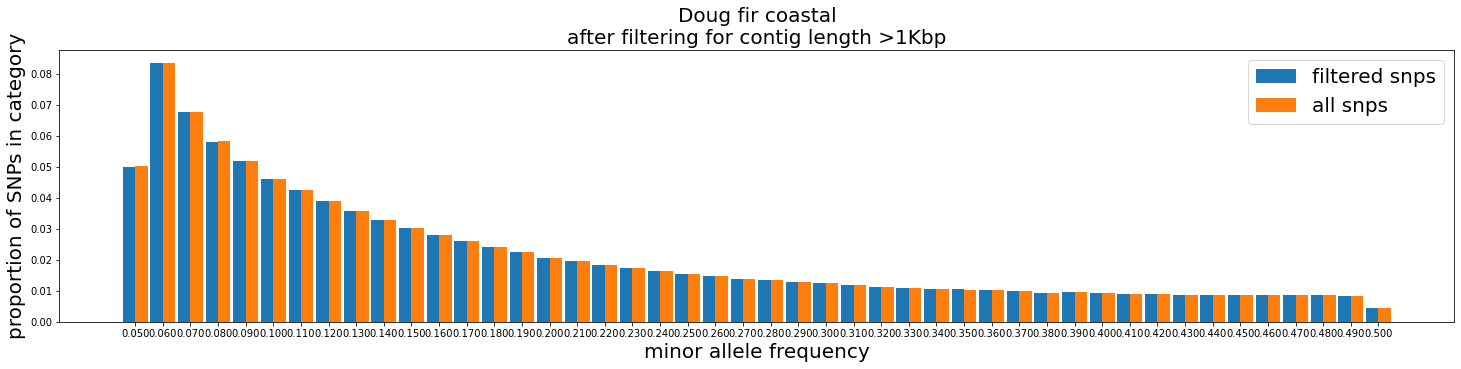

In [13]:
# compare MAF spectrum between depth-filtered and precursor
make_mafdict_fig(get_mafdict(reduced['AF'], roundto=2),
                 get_mafdict(snps['AF'], roundto=2),
                 title='Doug fir coastal\nafter filtering for contig length >1Kbp')

<a id='missing'></a>
#### try and reduce to no missing data 

Turns out I can't filter for no missing data, the MAF spectrum doesn't match well with MAF spectrum of all data. Filter instead for % missing below.

[top](#home)

In [14]:
def reduce_col(col):
    """Return list of loci with no missing data for pop.FREQ col."""
    return reduced[reduced[col].notnull()].index

In [15]:
# get loci from each pop without missing data
reduce_col_outs = []
for col in nb(freqcols):
    reduce_col_outs.append(reduce_col(col))

100%|██████████| 38/38 [00:17<00:00,  2.20it/s]


In [16]:
# combine returns to get loci with no missing data across pop.FREQ cols
nomissingloci = snps.index.tolist()
for out in nb(reduce_col_outs):
    nomissingloci = list(set(nomissingloci).intersection(out))
len(nomissingloci), luni(nomissingloci)

100%|██████████| 38/38 [00:10<00:00,  3.77it/s]


(256369, 256369)

In [17]:
# reduce snp table to no missing loci
reduced_nm = reduced[reduced.index.isin(nomissingloci)]
reduced_nm.head()

,DF_p1.FREQ,DF_p2.FREQ,DF_p23.FREQ,DF_p24.FREQ,DF_p25.FREQ,DF_p26.FREQ,DF_p27.FREQ,DF_p28.FREQ,DF_p10.FREQ,DF_p29.FREQ,DF_p30.FREQ,DF_p31.FREQ,DF_p32.FREQ,DF_p11.FREQ,DF_p12.FREQ,DF_p50.FREQ,DF_p51.FREQ,DF_p52.FREQ,DF_p53.FREQ,DF_p13.FREQ,DF_p6.FREQ,DF_p72.FREQ,DF_p14.FREQ,DF_p73.FREQ,DF_p74.FREQ,DF_p75.FREQ,DF_p76.FREQ,DF_p77.FREQ,DF_p78.FREQ,DF_p79.FREQ,DF_p80.FREQ,DF_p81.FREQ,DF_p15.FREQ,DF_p82.FREQ,DF_p83.FREQ,DF_p84.FREQ,DF_p16.FREQ,DF_p17.FREQ,CHROM,AF,MAF
jcf7190000000004-54589,86.67%,83.87%,89.13%,84.93%,83.58%,84%,58.21%,85.37%,71.67%,93.59%,80%,80.49%,78.33%,85.96%,100%,84.31%,89.29%,89.86%,61.9%,77.97%,91.53%,63.38%,76.19%,72.88%,86.36%,91.38%,65.67%,93.67%,80.52%,72.31%,74.36%,79.31%,72.22%,79.73%,81.61%,58.97%,76.12%,86.36%,jcf7190000000004,0.803363,0.196637
jcf7190000000004-55528,37.08%,35%,39.68%,34.34%,35.82%,34.55%,45.45%,40.32%,34.18%,43.66%,39.33%,60.42%,46.94%,45.88%,42.55%,30.38%,31.82%,63.51%,48.19%,32.93%,24.74%,45.35%,41.67%,44.29%,34.09%,58.24%,32.18%,35%,44.68%,46.59%,23.15%,21.18%,40.35%,43.86%,54.9%,25.53%,33.33%,15.38%,jcf7190000000004,0.392025,0.392025
jcf7190000000004-56179,10.48%,60.71%,35.38%,15.84%,37.5%,12.5%,29.67%,22.86%,18.52%,13.43%,22.34%,31.11%,30.95%,22.67%,12.37%,26.23%,27.5%,23.53%,13.19%,11.49%,29.41%,25.27%,18.29%,15.38%,19.23%,26.83%,19.57%,22.22%,23.3%,18.8%,19.3%,14.81%,24.29%,19.42%,17.86%,19.51%,12.9%,7.69%,jcf7190000000004,0.219374,0.219374
jcf7190000000004-57381,27.27%,44%,50%,31.15%,56.25%,36.73%,35.42%,42%,39.22%,34.78%,26.15%,65.52%,53.19%,32.14%,49.09%,25.58%,35.56%,68.89%,48.15%,43.86%,29.31%,55.38%,34.92%,53.19%,50%,56.06%,23.44%,41.67%,53.52%,37.68%,39.71%,29.69%,53.19%,49.23%,57.69%,25%,37.5%,29.17%,jcf7190000000004,0.421695,0.421695
jcf7190000000004-289709,32.79%,42.86%,16.67%,31.85%,27.96%,33.33%,18.48%,20.83%,31.76%,21.98%,11.57%,20%,38.67%,27.72%,30.33%,31.08%,20.9%,2.38%,10.16%,15.52%,29.91%,28.24%,18%,11.46%,26.67%,12.12%,10.53%,19.88%,25.17%,35.54%,20.13%,20.41%,29.59%,19.67%,39.5%,17.5%,27.78%,30%,jcf7190000000004,0.239329,0.239329


46
46


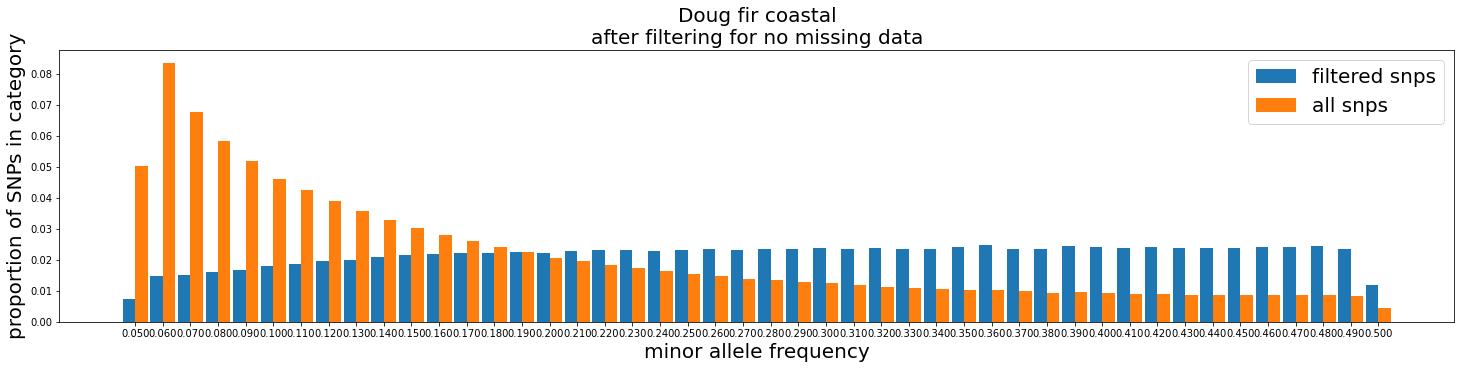

In [18]:
# compare MAF spectrum between no-missing and precursor
make_mafdict_fig(get_mafdict(reduced_nm['AF'], roundto=2),
                 get_mafdict(snps['AF'], roundto=2),
                 title='Doug fir coastal\nafter filtering for no missing data')

<center> SETTING PERC TO 0.25 MEANS NO LOCI WERE FILTERED BY MAF
    
    if I tried filtering <= 10% missing data, the MAF spectrum looked weird, leaving the code inplace. As-is (<25% missing data) will allow more contigs

<a id='random'></a>
#### choose one snp per contig at random

[top](#home)

In [19]:
def choose_random_loci(df):
    """For each chrom in df['CHROM'], randomly choose 1 snp."""
    import pandas
    import random

    keep = []
    for chrom in uni(df['CHROM']):
        loci = df.loc[chrom, 'locus']
        if isinstance(loci, str):
            keep.append(loci)
            continue
        loci = loci.tolist()
        random.shuffle(loci)
        keep.append(loci[0])
    return keep
        
dview['uni'] = uni

In [20]:
# how many chroms do I send to a job? A: math.ceil(461.19)
luni(reduced['CHROM']), luni(reduced['CHROM'])/len(lview)

(25827, 461.19642857142856)

In [21]:
reduced.head()

,DF_p1.FREQ,DF_p2.FREQ,DF_p23.FREQ,DF_p24.FREQ,DF_p25.FREQ,DF_p26.FREQ,DF_p27.FREQ,DF_p28.FREQ,DF_p10.FREQ,DF_p29.FREQ,DF_p30.FREQ,DF_p31.FREQ,DF_p32.FREQ,DF_p11.FREQ,DF_p12.FREQ,DF_p50.FREQ,DF_p51.FREQ,DF_p52.FREQ,DF_p53.FREQ,DF_p13.FREQ,DF_p6.FREQ,DF_p72.FREQ,DF_p14.FREQ,DF_p73.FREQ,DF_p74.FREQ,DF_p75.FREQ,DF_p76.FREQ,DF_p77.FREQ,DF_p78.FREQ,DF_p79.FREQ,DF_p80.FREQ,DF_p81.FREQ,DF_p15.FREQ,DF_p82.FREQ,DF_p83.FREQ,DF_p84.FREQ,DF_p16.FREQ,DF_p17.FREQ,CHROM,AF,MAF
jcf7190000000004-54508,4.62%,6.25%,15.91%,10.77%,NaN,0%,5.77%,5.41%,NaN,NaN,7.14%,2.22%,6.12%,4.92%,0%,17.24%,20.37%,0%,0%,1.75%,2.38%,NaN,28.57%,20.37%,3.03%,15.38%,2.99%,2.94%,NaN,7.14%,2.67%,20.69%,7.14%,NaN,5.63%,3.7%,4.48%,10.71%,jcf7190000000004,0.077402,0.077402
jcf7190000000004-54540,25.37%,30.56%,NaN,35.82%,35.71%,43.64%,32.14%,23.68%,30.36%,30%,36.21%,52.27%,21.28%,34.92%,27.54%,30%,20%,48.53%,57.41%,32.69%,49.06%,27.4%,29.82%,23.88%,40%,53.62%,32.35%,44.44%,34.21%,40.32%,23.68%,29.63%,30%,27.63%,44.16%,NaN,32.84%,NaN,jcf7190000000004,0.346552,0.346552
jcf7190000000004-54587,1.32%,9.68%,20.83%,9.72%,6.15%,5.77%,4.48%,4.88%,NaN,14.1%,5.45%,0%,4.92%,1.72%,0%,15.38%,42.11%,37.68%,NaN,NaN,1.72%,10.14%,21.88%,20.69%,8.51%,22.81%,5.97%,13.58%,8.97%,2.99%,NaN,18.97%,1.92%,10.39%,10.34%,NaN,5.97%,NaN,jcf7190000000004,0.109135,0.109135
jcf7190000000004-54589,86.67%,83.87%,89.13%,84.93%,83.58%,84%,58.21%,85.37%,71.67%,93.59%,80%,80.49%,78.33%,85.96%,100%,84.31%,89.29%,89.86%,61.9%,77.97%,91.53%,63.38%,76.19%,72.88%,86.36%,91.38%,65.67%,93.67%,80.52%,72.31%,74.36%,79.31%,72.22%,79.73%,81.61%,58.97%,76.12%,86.36%,jcf7190000000004,0.803363,0.196637
jcf7190000000004-54643,14.71%,NaN,2.04%,22.64%,28.95%,34.43%,12.5%,12.5%,11.48%,18.18%,11.29%,31.91%,6.25%,21.82%,0%,23.4%,8%,28.57%,18.46%,21.05%,14.29%,25.33%,15.71%,13.56%,37.78%,1.54%,18.46%,22.22%,30%,21.05%,NaN,12.12%,19.12%,19.48%,27.91%,9.76%,20.27%,NaN,jcf7190000000004,0.181756,0.181756


In [22]:
# change the index for easy sending
reduced['locus'] = reduced.index.tolist()
reduced.index = reduced['CHROM'].tolist()

In [23]:
nrow(reduced), luni(reduced['locus'])

(801423, 801423)

In [24]:
# choose random loci in parallel
thresh = math.ceil(luni(reduced['CHROM'])/len(lview))
jobs = []
tosend = []
i = 0
numchroms = luni(reduced['CHROM'])
for chrom in nb(uni(reduced['CHROM'])):
    tosend.append(chrom)
    if len(tosend) == thresh or (i+1)==numchroms:
        jobs.append(lview.apply_async(choose_random_loci, reduced.loc[tosend, :]))
        tosend = []
    i += 1
watch_async(jobs)

100%|██████████| 25827/25827 [00:12<00:00, 2096.26it/s]



Watching 56 jobs ...


100%|██████████| 56/56 [00:00<00:00, 278295.05it/s]


In [25]:
# get returns from jobs
randomloci = []
for j in jobs:
    randomloci.extend(j.r)
len(randomloci) == luni(reduced['CHROM'])

True

In [26]:
# reset index, reduce reduced to only randomloci
red = reduced[reduced['locus'].isin(randomloci)].copy()
print(nrow(red), len(randomloci))
red.head()

25827 25827


,DF_p1.FREQ,DF_p2.FREQ,DF_p23.FREQ,DF_p24.FREQ,DF_p25.FREQ,DF_p26.FREQ,DF_p27.FREQ,DF_p28.FREQ,DF_p10.FREQ,DF_p29.FREQ,DF_p30.FREQ,DF_p31.FREQ,DF_p32.FREQ,DF_p11.FREQ,DF_p12.FREQ,DF_p50.FREQ,DF_p51.FREQ,DF_p52.FREQ,DF_p53.FREQ,DF_p13.FREQ,DF_p6.FREQ,DF_p72.FREQ,DF_p14.FREQ,DF_p73.FREQ,DF_p74.FREQ,DF_p75.FREQ,DF_p76.FREQ,DF_p77.FREQ,DF_p78.FREQ,DF_p79.FREQ,DF_p80.FREQ,DF_p81.FREQ,DF_p15.FREQ,DF_p82.FREQ,DF_p83.FREQ,DF_p84.FREQ,DF_p16.FREQ,DF_p17.FREQ,CHROM,AF,MAF,locus
jcf7190000000004,10%,9.38%,13.43%,12.77%,11.76%,15.15%,1.28%,5%,22.08%,NaN,17.53%,NaN,20%,29.09%,17.46%,11.43%,25%,NaN,15.49%,16.67%,40.58%,18.52%,13.04%,17.65%,0%,2.44%,13.64%,17.2%,8.33%,16.92%,NaN,10.23%,19.12%,21%,9.62%,8.7%,3.19%,6.25%,jcf7190000000004,0.141136,0.141136,jcf7190000000004-480279
jcf7190000000008,6.11%,9.09%,9.49%,6.43%,12.41%,8.03%,13.97%,8.47%,4.9%,6.35%,14.38%,10%,6.02%,8.64%,23.38%,12.63%,11.69%,1.19%,NaN,6.99%,8.33%,7.63%,7.08%,10.58%,8.57%,8.18%,7.95%,NaN,10.93%,6.67%,7.55%,5.04%,6.72%,8%,5.17%,20.31%,5.73%,20.83%,jcf7190000000008,0.093236,0.093236,jcf7190000000008-430281
jcf7190000000011,29.5%,20.88%,28.89%,30.64%,23.62%,32.51%,36.11%,29.18%,30.87%,21.3%,24.61%,21.05%,29.29%,25.83%,32.14%,21.9%,22.97%,41.71%,50.47%,21.39%,28.86%,25.86%,25.94%,21.37%,20.12%,18.97%,26.04%,25.5%,24.54%,21.19%,18.09%,19.38%,19.61%,30.73%,28.61%,29.88%,18.25%,22.12%,jcf7190000000011,0.263417,0.263417,jcf7190000000011-190610
jcf7190000000019,0%,NaN,8%,2%,6.25%,2.5%,4.65%,5.26%,11.67%,NaN,NaN,9.09%,2.13%,4.84%,0%,11.94%,6.38%,1.54%,1.85%,NaN,4.76%,6.67%,1.67%,6.9%,2.7%,5.36%,6.45%,1.49%,5.13%,5.19%,9.33%,5.88%,NaN,5.41%,2.17%,12.5%,NaN,4.76%,jcf7190000000019,0.051147,0.051147,jcf7190000000019-15500
jcf7190000000023,1.69%,4.17%,NaN,6.25%,0%,17.78%,0%,3.77%,NaN,8.33%,NaN,6.06%,9.52%,9.09%,14.08%,NaN,4.88%,3.12%,14.29%,16.44%,1.79%,12.86%,NaN,11.43%,3.03%,19.12%,NaN,12.5%,4.76%,4.76%,8.51%,5.66%,5.56%,NaN,14.46%,NaN,7.69%,4%,jcf7190000000023,0.078324,0.078324,jcf7190000000023-30169


In [27]:
# reset index
reduced = red.copy()
reduced.index = reduced['locus'].tolist()
reduced.shape

(25827, 42)

46
46


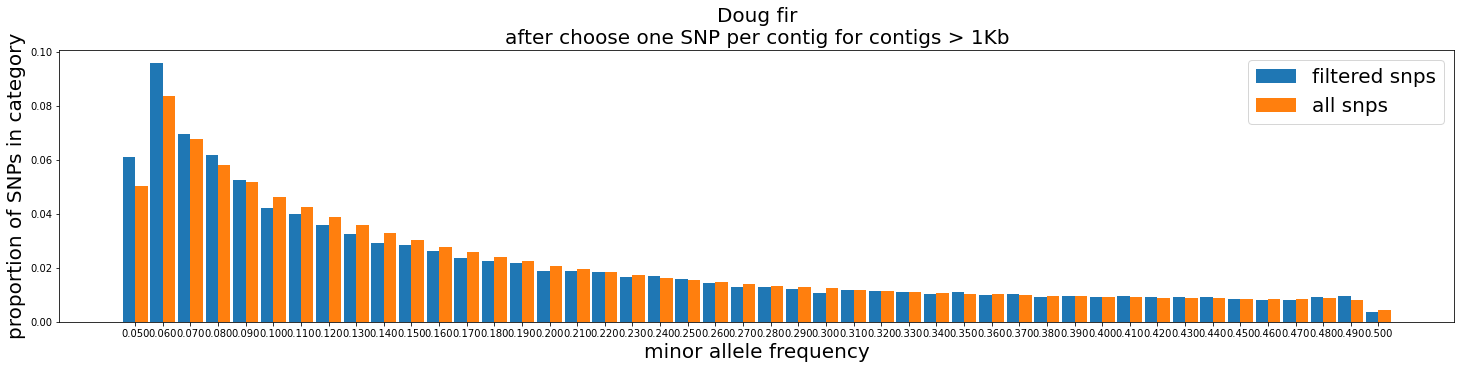

In [28]:
# compare distributions
make_mafdict_fig(get_mafdict(reduced['AF'], roundto=2),
                 get_mafdict(snps['AF'], roundto=2),
                 title='Doug fir\nafter choose one SNP per contig for contigs > 1Kb')

<a id='r2thresh'></a>
#### get an idea of r2 values so we can determine an empirical high-end cutoff

[top](#home)

In [29]:
def getfreqs(myloci):
    """Get the population ALT frequency as a float (reported as a str in table).
    
    Returns
    -------
    list of tuples
        - first element = locus name
        - second element = pandas.Series
    """
    rets = []
    for locus in myloci:
        rets.append((locus, reduced.loc[locus, freqcols].str.replace("%", "").astype(float) / 100))
    return rets
dview['getfreqs'] = getfreqs
dview['freqcols'] = freqcols
dview['reduced'] = reduced[freqcols]

def getr2(myloci):
    from scipy.stats import pearsonr
    from numpy import logical_or
    from tqdm.notebook import tqdm as nb

    freqs = dict((locus, freqs) for (locus,freqs) in getfreqs(myloci))

    r2vals = []
    i = 0
    for locusi in nb(myloci):
        for j,locusj in enumerate(myloci):
            if i < j:
                nas = logical_or(freqs[locusi].isnull(), freqs[locusj].isnull())
                r2 = pearsonr(freqs[locusi][~nas], freqs[locusj][~nas])[0]**2
                r2vals.append(r2)
        i += 1
    return r2vals

In [34]:
jobs = send_chunks(getr2, randomloci, 240, lview)
watch_async(jobs)


Watching 108 jobs ...


100%|██████████| 108/108 [01:35<00:00,  1.13it/s]


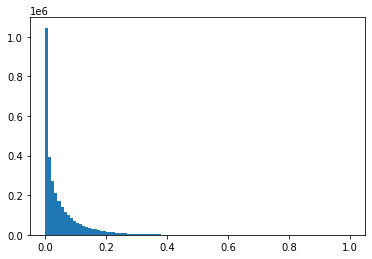

In [35]:
r2vals = []
for j in jobs:
    r2vals.extend(j.r)
plt.hist(r2vals, bins=100)
plt.show()

In [36]:
# what is 99.99th percentile?
sorted(r2vals)[math.ceil(len(r2vals)*.9999)]  # 0.6590580236728133

0.650941106749831

In [37]:
# get 99.9th percentile
sorted(r2vals)[math.ceil(len(r2vals)*.999)]  # 0.485115463446523

0.4823364701095914

In [38]:
# get 99.5th percentile
sorted(r2vals)[math.ceil(len(r2vals)*.995)]  # 0.36179385314955925

0.3577612962381966

In [39]:
# what is 99th percentile?
sorted(r2vals)[math.ceil(len(r2vals)*.99)]  # 0.30929946536470604

0.30576160117198925

In [40]:
# what is 98th percentile?
sorted(r2vals)[math.ceil(len(r2vals)*.98)]  # 0.25600050331909613

0.25326042480027217

In [41]:
# what is 97th percentile?
sorted(r2vals)[math.ceil(len(r2vals)*.97)]  # 0.22495857239961842

0.22233538967674818

In [42]:
# what perc is 0.2
for i,x in enumerate(sorted(r2vals)):
    if x > 0.2:
        print(i)  # how many loci are below this perc?  # 94103
        break
(i+1)/len(r2vals)  # 0.030463626325281372

2955127


0.9596157287032175

In [43]:
# what perc is 0.3
for i,x in enumerate(sorted(r2vals)):
    if x > 0.3:
        print(i)  # how many loci are below this perc?  # 97226
        break
(i+1)/len(r2vals)  # 0.03147461315914448 

3046286


0.9892176986391582

In [44]:
# what perc is 0.3606818877742702 (to compare with jack pine)
for i,x in enumerate(sorted(r2vals)):
    if x > 0.3606818877742702:
        print(i)  # how many loci are below this perc?  # 97820
        break
(i+1)/len(r2vals)  # 0.03166690460304927

3064647


0.9951800476117644

In [45]:
# use 99.5th percentile
# using the 99th percentile reduce the number of loci < 4000
r2thresh = 0.3577612962381966 # 0.36179385314955925

<a id='prune'></a>
#### LD prune random loci

[top](#home)

In [46]:
# number of loci starting out
reduced.shape

(25827, 42)

In [47]:
len(randomloci)

25827

In [48]:
snps.shape, reduced.shape

((803597, 80), (25827, 42))

In [49]:
# num pops
len(freqcols)

38

In [50]:
# attach data to engines

# dict with key=locus, val = list of freqs for that locus
freqs = dict((locus, freqs) for (locus,freqs) in getfreqs(randomloci))

dview['freqs'] = freqs
dview['reduced'] = None
len(freqs)

25827

In [51]:
def prune_em(compareto, locusi=None, r2thresh=None):
    """Prune loci by LD (r2thresh)."""
    from scipy.stats import pearsonr
    from numpy import logical_or
    
    drop = []
    for locusj in compareto:
        nas = logical_or(freqs[locusi].isnull(), freqs[locusj].isnull())
        r2 = pearsonr(freqs[locusi][~nas], freqs[locusj][~nas])[0]**2
#         print('r2 = ', r2)
        if r2 > r2thresh:
            drop.append(locusj)

    return locusi,drop

In [52]:
r2thresh

0.3577612962381966

In [53]:
# send locus along with all needed loci for pairwise comparisons to engines
# each locus (job) has r2 calculated for each of the remaining unique pairwise combinations
# so the first job compares locus1 to locus2-locusn, second job locus2 to locus3-locusn ... 
jobs = []
for i, locusi in enumerate(nb(randomloci)):
    tosend = randomloci[i+1:] # pairwise comparisons
    jobs.append(lview.apply_async(prune_em, tosend, **{'r2thresh':r2thresh, 'locusi':locusi}))

100%|██████████| 25827/25827 [04:19<00:00, 99.36it/s] 


In [54]:
t1 = dt.now()  # timer

In [57]:
# iterate jobs, if finished jobs are an unbroken sequenced 0:(n-1), check returns and cancel any loci iterations
    # downstream. eg if locus0 has r2 > r2thresh with locus100, drop locus100 and kill jobs[100] to save some time

# found = {-1: None}  # comment this out after running this the first time in case I want to interrupt and restart
# keep = list(randomloci)  # comment this out after running this the first time in case I want to interrupt and restart
maxx = -1
while maxx < (len(randomloci) - 1):
    i = 0  # jcount
    for j in tnb(jobs):
        if j.ready() and (i-1 in found.keys()) and (i not in found.keys()):
            found[i] = True
            try:
                locusi, drop = j.r
            except: # CancelledError
                continue
            if locusi in keep:
                for locusj in drop:
                    if locusj in keep:
                        job_idx = randomloci.index(locusj)
    #                     print('\tcanceling ', job_idx, '. ', locusj, randomloci[job_idx])
                        jobs[job_idx].cancel()
                        keep.remove(locusj)
        i += 1
    maxx = max(found.keys())
    if maxx+1 < len(randomloci):
        update([(jobs[maxx+1].ready(), maxx, len(found.keys()), len(keep))])
        time.sleep(10)
len(keep)

(True, 25187, 25189, 4935)


4935

In [58]:
# I forgot to specify exact time, so this was rounded up to 3 hours
t2 = dt.now()
formatclock(t2-t1)

'0-03:00:00'

In [59]:
# save
baydir = makedir(op.join(snpdir, 'baypass'))
pkl = op.join(baydir, 'lessthan25perc-missing-data_20-dp-1000_random-snps_1-per-contig-gt1Kbp_r2-lessthan-p3578.pkl')
pkldump(keep, pkl)

46
46


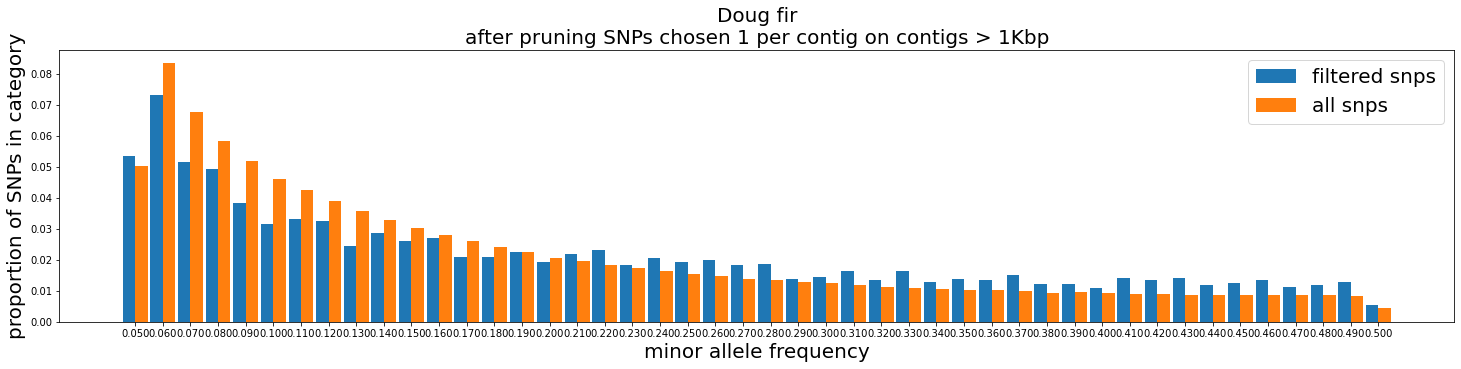

In [60]:
# compare distributions
keeping = reduced[reduced.index.isin(keep)].copy()
make_mafdict_fig(get_mafdict(keeping['AF'], roundto=2),
                 get_mafdict(snps['AF'], roundto=2),
                 title='Doug fir\nafter pruning SNPs chosen 1 per contig on contigs > 1Kbp')

<a id='infiles'></a>
# create infiles to baypass to estimate neutral structure

[top](#home)

<a id='genotyping'></a>
#### <center> genotyping data

"The genotyping data file is simply organized as a matrix with
nsnp rows and 2 ∗ npop columns. The row field separator is a space. More
precisely, each row corresponds to one marker and the number of columns is
twice the number of populations because each pair of numbers corresponds to
each allele (or read counts for PoolSeq experiment) counts in one population"

In [ ]:
# RESTART NOTEBOOK! I used lower depth threshold for structure estimation

In [2]:
latest_commit()

##################################################################
Current commit of pythonimports:
commit 4937ed6baded6e6e058c905e26e9ae16bfe3f0d9
Author: Brandon <lindb@vcu.edu>
Date:   Tue Dec 1 11:28:39 2020 -0700
Today:	December 15, 2020 - 14:07:50
##################################################################



In [3]:
lview,dview = get_client()

56 56


In [4]:
baydir

'/data/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/coastal_variety_with-p6/03_maf-p05_RD-recalculated_FDC/baypass'

In [5]:
# see what's in baydir
fs(baydir, bnames=True, dirs=False)

['lessthan25perc-missing-data_20-dp-1000_random-snps_1-per-contig-gt1Kbp_r2-lessthan-p3578.pkl']

In [6]:
# load LD-pruned loci
prunedloci = pklload(op.join(baydir, 'lessthan25perc-missing-data_20-dp-1000_random-snps_1-per-contig-gt1Kbp_r2-lessthan-p3578.pkl'))
len(prunedloci)

4935

In [7]:
f = op.join(snpdir, 'DF_pooled-varscan_all_bedfiles_SNP_FDC_maf_RD-recalculated.txt')
snps = parallel_read(f,
                     lview=lview, dview=dview,
                     verbose=False)
print(snps.shape)
snps.index = snps['locus'].tolist()
snps.head()


Watching 56 parallel_read() jobs ...


DF_pooled-varscan_all_bedfiles_SNP_FDC_maf_RD-recalculated.txt: 100%|██████████| 56/56 [00:28<00:00,  1.98it/s]


(2254116, 319)


,CHROM,POS,REF,ALT,AF,QUAL,TYPE,FILTER,ADP,WT,HET,HOM,NC,DF_p1.GT,DF_p1.GQ,DF_p1.SDP,DF_p1.DP,DF_p1.FREQ,DF_p1.PVAL,DF_p1.AD,DF_p1.RD,DF_p2.GT,DF_p2.GQ,DF_p2.SDP,DF_p2.DP,DF_p2.FREQ,DF_p2.PVAL,DF_p2.AD,DF_p2.RD,DF_p23.GT,DF_p23.GQ,DF_p23.SDP,DF_p23.DP,DF_p23.FREQ,DF_p23.PVAL,DF_p23.AD,DF_p23.RD,DF_p24.GT,DF_p24.GQ,DF_p24.SDP,DF_p24.DP,DF_p24.FREQ,DF_p24.PVAL,DF_p24.AD,DF_p24.RD,DF_p25.GT,DF_p25.GQ,DF_p25.SDP,DF_p25.DP,DF_p25.FREQ,...,DF_p15.GT,DF_p15.GQ,DF_p15.SDP,DF_p15.DP,DF_p15.FREQ,DF_p15.PVAL,DF_p15.AD,DF_p15.RD,DF_p82.GT,DF_p82.GQ,DF_p82.SDP,DF_p82.DP,DF_p82.FREQ,DF_p82.PVAL,DF_p82.AD,DF_p82.RD,DF_p83.GT,DF_p83.GQ,DF_p83.SDP,DF_p83.DP,DF_p83.FREQ,DF_p83.PVAL,DF_p83.AD,DF_p83.RD,DF_p84.GT,DF_p84.GQ,DF_p84.SDP,DF_p84.DP,DF_p84.FREQ,DF_p84.PVAL,DF_p84.AD,DF_p84.RD,DF_p16.GT,DF_p16.GQ,DF_p16.SDP,DF_p16.DP,DF_p16.FREQ,DF_p16.PVAL,DF_p16.AD,DF_p16.RD,DF_p17.GT,DF_p17.GQ,DF_p17.SDP,DF_p17.DP,DF_p17.FREQ,DF_p17.PVAL,DF_p17.AD,DF_p17.RD,locus,MAF
jcf7190000000000-77738,jcf7190000000000,77738,T,C,0.677466,-10.0,SNP,PASS,13,2,49,28,8,T/C,49.0,17,17.0,70.59%,0.000011,12.0,5.0,./.,NaN,6,NaN,NaN,NaN,NaN,NaN,T/C,18.0,8,8.0,NaN,0.012821,5.0,3.0,T/C,32.0,11,11.0,72.73%,5.160000e-04,8.0,3.0,T/C,29.0,15,15.0,53.33%,...,T/C,23.0,9,9.0,66.67%,0.004525,6.0,3.0,T/C,30.0,14,14.0,57.14%,9.661800e-04,8.0,6.0,C/C,91.0,24,24.0,83.33%,6.349300e-10,20.0,4.0,C/C,36.0,9,9.0,88.89%,0.000206,8.0,1.0,T/C,21.0,12,12.0,50%,6.865000e-03,6.0,6.0,T/C,32.0,11,11.0,72.73%,0.000516,8.0,3.0,jcf7190000000000-77738,0.322534
jcf7190000000000-77764,jcf7190000000000,77764,T,C,0.765881,-10.0,SNP,PASS,12,1,28,50,8,T/C,50.0,16,16.0,75%,0.000008,12.0,4.0,./.,NaN,4,NaN,NaN,NaN,NaN,NaN,./.,NaN,6,NaN,NaN,NaN,NaN,NaN,C/C,49.0,13,13.0,84.62%,1.009600e-05,11.0,2.0,T/C,34.0,15,15.0,60%,...,T/C,18.0,8,8.0,NaN,0.012821,5.0,3.0,T/C,22.0,10,10.0,60%,5.418000e-03,6.0,4.0,C/C,84.0,21,21.0,85.71%,3.760300e-09,18.0,3.0,C/C,31.0,8,8.0,87.5%,0.000699,7.0,1.0,T/C,27.0,11,11.0,63.64%,1.935000e-03,7.0,4.0,C/C,44.0,12,12.0,83.33%,0.000034,10.0,2.0,jcf7190000000000-77764,0.234119
jcf7190000000004-54418,jcf7190000000004,54418,T,C,0.354288,-10.0,SNP,PASS,36,1,86,0,0,T/C,39.0,47,47.0,25.53%,0.000109,12.0,35.0,T/C,27.0,20,20.0,40%,0.001638,8.0,12.0,T/C,26.0,31,31.0,25.81%,0.002333,8.0,23.0,T/C,32.0,43,43.0,23.26%,5.414800e-04,10.0,33.0,T/C,47.0,42,42.0,33.33%,...,T/C,44.0,38,38.0,35.14%,0.000034,13.0,25.0,T/C,74.0,53,53.0,40.38%,3.757800e-08,21.0,32.0,T/C,95.0,54,54.0,48.15%,2.717100e-10,26.0,28.0,T/C,27.0,21,21.0,38.1%,0.001724,8.0,13.0,T/C,47.0,44,44.0,31.82%,1.787300e-05,14.0,30.0,T/T,9.0,14,14.0,NaN,0.111110,3.0,11.0,jcf7190000000004-54418,0.354288
jcf7190000000004-54508,jcf7190000000004,54508,A,G,0.077402,-10.0,SNP,PASS,53,67,20,0,0,A/A,89.0,65,65.0,4.62%,0.122090,3.0,62.0,A/A,40.0,32,32.0,6.25%,0.246030,2.0,30.0,A/G,22.0,44,44.0,15.91%,0.006036,7.0,37.0,A/G,21.0,65,65.0,10.77%,6.590400e-03,7.0,58.0,A/G,15.0,67,67.0,NaN,...,A/A,49.0,42,42.0,7.14%,0.120480,3.0,39.0,A/G,15.0,71,71.0,NaN,2.905800e-02,5.0,66.0,A/A,91.0,71,71.0,5.63%,5.985000e-02,4.0,67.0,A/A,41.0,27,27.0,3.7%,0.500000,1.0,26.0,A/A,93.0,67,67.0,4.48%,1.221800e-01,3.0,64.0,A/A,28.0,28,28.0,10.71%,0.118180,3.0,25.0,jcf7190000000004-54508,0.077402
jcf7190000000004-54540,jcf7190000000004,54540,A,G,0.346552,-10.0,SNP,PASS,56,1,58,28,0,A/G,56.0,67,67.0,25.37%,0.000002,17.0,50.0,A/G,37.0,36,36.0,30.56%,0.000199,11.0,25.0,A/G,18.0,47,47.0,NaN,0.013188,6.0,41.0,A/G,83.0,67,67.0,35.82%,4.810900e-09,24.0,43.0,A/G,86.0,70,70.0,35.71%,...,A/G,50.0,50,50.0,30%,0.000009,15.0,35.0,A/G,70.0,76,76.0,27.63%,9.593900e-08,21.0,55.0,A/G,122.0,77,77.0,44.16%,5.202800e-13,34.0,43.0,A/G,19.0,34,34.0,NaN,0.012287,6.0,28.0,A/G,75.0,67,67.0,32.84%,3.020700e-08,22.0,45.0,A/G,15.0,26,26.0,NaN,0.025310,5.0,21.0,jcf7190000000004-54540,0.346552


In [8]:
# get pruned SNPs from read-in
reduced = snps[snps.index.isin(prunedloci)].copy()
reduced.shape, snps.shape

((4935, 319), (2254116, 319))

In [9]:
# all LD-pruned loci are in full set? A: yes!
assert len(set(prunedloci).intersection(reduced.index)) == len(prunedloci)

In [10]:
# how many pops?
len([col for col in reduced.columns if '.FREQ' in col])

38

In [12]:
# create the neutral gfile using the prunedloci
neutral_read_counts = get_counts(prunedloci, numpops=38)
neutral_read_counts.head()

100%|██████████| 4935/4935 [00:07<00:00, 624.20it/s]


,DF_p1-major,DF_p1-minor,DF_p2-major,DF_p2-minor,DF_p23-major,DF_p23-minor,DF_p24-major,DF_p24-minor,DF_p25-major,DF_p25-minor,DF_p26-major,DF_p26-minor,DF_p27-major,DF_p27-minor,DF_p28-major,DF_p28-minor,DF_p10-major,DF_p10-minor,DF_p29-major,DF_p29-minor,DF_p30-major,DF_p30-minor,DF_p31-major,DF_p31-minor,DF_p32-major,DF_p32-minor,DF_p11-major,DF_p11-minor,DF_p12-major,DF_p12-minor,DF_p50-major,DF_p50-minor,DF_p51-major,DF_p51-minor,DF_p52-major,DF_p52-minor,DF_p53-major,DF_p53-minor,DF_p13-major,DF_p13-minor,DF_p6-major,DF_p6-minor,DF_p72-major,DF_p72-minor,DF_p14-major,DF_p14-minor,DF_p73-major,DF_p73-minor,DF_p74-major,DF_p74-minor,DF_p75-major,DF_p75-minor,DF_p76-major,DF_p76-minor,DF_p77-major,DF_p77-minor,DF_p78-major,DF_p78-minor,DF_p79-major,DF_p79-minor,DF_p80-major,DF_p80-minor,DF_p81-major,DF_p81-minor,DF_p15-major,DF_p15-minor,DF_p82-major,DF_p82-minor,DF_p83-major,DF_p83-minor,DF_p84-major,DF_p84-minor,DF_p16-major,DF_p16-minor,DF_p17-major,DF_p17-minor
jcf7190000105690-163361,81,8,14,6,30,5,72,19,46,17,52,12,71,11,43,13,66,13,38,11,52,25,23,21,38,21,41,27,95,5,33,21,22,15,39,18,38,21,58,20,67,18,40,33,52,22,41,20,26,5,35,39,24,29,50,28,56,37,44,36,67,23,48,24,48,17,44,26,69,21,18,8,40,43,15,8
jcf7190000031468-186236,96,11,28,2,48,7,74,17,66,10,0,0,63,3,46,7,69,4,55,8,0,0,35,11,46,4,84,3,65,13,63,11,38,7,44,18,67,11,97,12,76,7,63,12,64,13,53,14,50,7,77,9,99,9,110,10,80,23,78,19,96,13,84,17,36,21,76,21,87,19,0,0,79,20,0,0
jcf7190000049708-268039,115,21,39,4,71,31,126,17,130,3,94,13,113,16,98,19,100,28,117,1,125,10,94,15,78,17,88,18,127,3,114,2,80,8,120,4,105,11,123,1,105,15,137,0,96,0,104,0,71,2,98,17,0,0,176,0,164,0,113,8,170,0,146,0,107,0,143,0,190,4,77,1,132,0,39,1
jcf7190000028883-64815,44,3,20,1,37,2,53,1,37,4,47,1,46,3,38,3,42,3,35,1,79,4,27,2,35,4,0,0,59,1,43,1,0,0,53,4,44,1,52,2,44,1,69,13,0,0,44,1,30,1,56,9,46,2,41,2,76,2,38,3,47,4,51,3,27,3,49,2,0,0,25,4,56,2,0,0
jcf7190000085008-69518,48,31,13,15,24,30,36,36,24,25,36,28,38,26,42,14,40,24,29,35,46,26,36,23,28,19,34,26,44,40,48,20,21,26,40,33,49,13,58,34,51,30,47,41,45,17,44,22,37,22,49,41,44,29,37,46,47,20,37,35,41,38,38,32,21,25,49,43,34,47,18,10,40,27,17,8


In [13]:
# assert that DP = RD + AD
dpcols = [col for col in reduced.columns if '.DP' in col]
for dpcol in dpcols:
    pop = dpcol.split(".")[0]
    adcol = f"{pop}.AD"
    rdcol = f"{pop}.RD"
    assert all(reduced[dpcol] == (reduced[adcol]+reduced[rdcol]))

In [14]:
baydir

'/data/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/coastal_variety_with-p6/03_maf-p05_RD-recalculated_FDC/baypass'

In [15]:
# make sure missing data makes sense
majorcols = [col for col in neutral_read_counts.columns if 'major' in col]
print(len(majorcols))  # num pops
for locus in neutral_read_counts.index:
    misscount = 0
    for col in majorcols:
        pop = col.split("-")[0]
        if neutral_read_counts.loc[locus, col] == 0 and neutral_read_counts.loc[locus, "%s-minor" % pop] == 0:
            misscount += 1
    if misscount / len(majorcols) > 0.25:
        print('crap ', locus)

38


In [16]:
# save
neutral_read_counts.to_csv(op.join(baydir, 'coastal_neutral_gfile_HEADERIDX.txt'), sep='\t', index=True)
neutral_read_counts.to_csv(op.join(baydir, 'coastal_neutral_gfile_noheaderidx.txt'), sep='\t', index=False, header=False)

<a id='poolsizefile'></a>
#### <center> poolsizefile

"For Pool–Seq experiment, the haploid size (twice the number of pooled in- dividuals for diploid species) of each population should be provided. ... The order of the populations in the pool size file must be the same as in the allele count (and the covariate) data file(s)."

</center>

[top](#home)

In [17]:
DIR

'/data/projects/pool_seq/DF_datasets'

In [18]:
# the reason the ploidy.keys() are not in same order of table ...
# ... is because varscan puts Sample1.X then Sample10.X ... (JP_p31 is the 10th file into varscan)
ploidy = pklload(op.join(DIR, 'DF_pooled_GEA/DF_pooled/pkl_files/ploidy.pkl'))['DF_pooled']  # get correct order
count = 0
for k,v in ploidy.items():
    print(k,v)
    count += 1
    if count == 5:
        break

DF_p1 80
DF_p10 80
DF_p11 80
DF_p12 80
DF_p13 80


In [19]:
# get ploidy of pops in same order as in gfile
pops = [col.replace("-major","") for col in neutral_read_counts.columns if '-major' in col]
vals = OrderedDict()
for pop in pops:
    vals[pop] = OrderedDict()
    vals[pop][0] = ploidy[pop]
poolsizefile = pd.DataFrame(vals)
poolsizefile

,DF_p1,DF_p2,DF_p23,DF_p24,DF_p25,DF_p26,DF_p27,DF_p28,DF_p10,DF_p29,DF_p30,DF_p31,DF_p32,DF_p11,DF_p12,DF_p50,DF_p51,DF_p52,DF_p53,DF_p13,DF_p6,DF_p72,DF_p14,DF_p73,DF_p74,DF_p75,DF_p76,DF_p77,DF_p78,DF_p79,DF_p80,DF_p81,DF_p15,DF_p82,DF_p83,DF_p84,DF_p16,DF_p17
0,80,80,80,80,80,76,80,80,80,78,80,80,80,80,80,80,80,80,80,80,80,80,80,80,80,80,80,80,80,80,66,80,80,78,80,78,80,80


In [20]:
# num pops
len(poolsizefile.columns)

38

In [21]:
# compare pop order to poolsizefile
neutral_read_counts.head()

,DF_p1-major,DF_p1-minor,DF_p2-major,DF_p2-minor,DF_p23-major,DF_p23-minor,DF_p24-major,DF_p24-minor,DF_p25-major,DF_p25-minor,DF_p26-major,DF_p26-minor,DF_p27-major,DF_p27-minor,DF_p28-major,DF_p28-minor,DF_p10-major,DF_p10-minor,DF_p29-major,DF_p29-minor,DF_p30-major,DF_p30-minor,DF_p31-major,DF_p31-minor,DF_p32-major,DF_p32-minor,DF_p11-major,DF_p11-minor,DF_p12-major,DF_p12-minor,DF_p50-major,DF_p50-minor,DF_p51-major,DF_p51-minor,DF_p52-major,DF_p52-minor,DF_p53-major,DF_p53-minor,DF_p13-major,DF_p13-minor,DF_p6-major,DF_p6-minor,DF_p72-major,DF_p72-minor,DF_p14-major,DF_p14-minor,DF_p73-major,DF_p73-minor,DF_p74-major,DF_p74-minor,DF_p75-major,DF_p75-minor,DF_p76-major,DF_p76-minor,DF_p77-major,DF_p77-minor,DF_p78-major,DF_p78-minor,DF_p79-major,DF_p79-minor,DF_p80-major,DF_p80-minor,DF_p81-major,DF_p81-minor,DF_p15-major,DF_p15-minor,DF_p82-major,DF_p82-minor,DF_p83-major,DF_p83-minor,DF_p84-major,DF_p84-minor,DF_p16-major,DF_p16-minor,DF_p17-major,DF_p17-minor
jcf7190000105690-163361,81,8,14,6,30,5,72,19,46,17,52,12,71,11,43,13,66,13,38,11,52,25,23,21,38,21,41,27,95,5,33,21,22,15,39,18,38,21,58,20,67,18,40,33,52,22,41,20,26,5,35,39,24,29,50,28,56,37,44,36,67,23,48,24,48,17,44,26,69,21,18,8,40,43,15,8
jcf7190000031468-186236,96,11,28,2,48,7,74,17,66,10,0,0,63,3,46,7,69,4,55,8,0,0,35,11,46,4,84,3,65,13,63,11,38,7,44,18,67,11,97,12,76,7,63,12,64,13,53,14,50,7,77,9,99,9,110,10,80,23,78,19,96,13,84,17,36,21,76,21,87,19,0,0,79,20,0,0
jcf7190000049708-268039,115,21,39,4,71,31,126,17,130,3,94,13,113,16,98,19,100,28,117,1,125,10,94,15,78,17,88,18,127,3,114,2,80,8,120,4,105,11,123,1,105,15,137,0,96,0,104,0,71,2,98,17,0,0,176,0,164,0,113,8,170,0,146,0,107,0,143,0,190,4,77,1,132,0,39,1
jcf7190000028883-64815,44,3,20,1,37,2,53,1,37,4,47,1,46,3,38,3,42,3,35,1,79,4,27,2,35,4,0,0,59,1,43,1,0,0,53,4,44,1,52,2,44,1,69,13,0,0,44,1,30,1,56,9,46,2,41,2,76,2,38,3,47,4,51,3,27,3,49,2,0,0,25,4,56,2,0,0
jcf7190000085008-69518,48,31,13,15,24,30,36,36,24,25,36,28,38,26,42,14,40,24,29,35,46,26,36,23,28,19,34,26,44,40,48,20,21,26,40,33,49,13,58,34,51,30,47,41,45,17,44,22,37,22,49,41,44,29,37,46,47,20,37,35,41,38,38,32,21,25,49,43,34,47,18,10,40,27,17,8


In [22]:
# save, no need to name as 'neutral'
poolsizefile.to_csv(op.join(baydir, 'coastal_poolsizefile_HEADERIDX.txt'), sep='\t', index=False)
poolsizefile.to_csv(op.join(baydir, 'coastal_poolsizefile_noheaderidx.txt'), sep='\t', index=False, header=False)

<a id='covariance'></a>
#  create 5 replicate estimates of the covariance matrix


[top](#home)

In [23]:
baydir

'/data/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/coastal_variety_with-p6/03_maf-p05_RD-recalculated_FDC/baypass'

<a id='shfiles'></a>
## make shfiles for cedar server

[top](#home)

In [24]:
# get gfile and poolsize file paths
gfile = op.join(baydir, 'coastal_neutral_gfile_noheaderidx.txt')
poolsizefile = op.join(baydir, 'coastal_poolsizefile_noheaderidx.txt')
all([op.exists(gfile), op.exists(poolsizefile)])

True

In [25]:
gfile

'/data/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/coastal_variety_with-p6/03_maf-p05_RD-recalculated_FDC/baypass/coastal_neutral_gfile_noheaderidx.txt'

In [26]:
poolsizefile

'/data/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/coastal_variety_with-p6/03_maf-p05_RD-recalculated_FDC/baypass/coastal_poolsizefile_noheaderidx.txt'

In [29]:
# rsync files to cedar
for src in nb([gfile, poolsizefile]):
    dst = op.join('cedar:/scratch/lindb/coastal_baypass', op.basename(src))
    rsync(src, dst)

100%|██████████| 2/2 [00:03<00:00,  1.96s/it]


In [30]:
# create sbatch files to run baypass omega estimation

# cedar paths to files (I rsynced files here to cedar server)
cedar_gfile = '/scratch/lindb/coastal_baypass/coastal_neutral_gfile_noheaderidx.txt'
cedar_poolsizefile = '/scratch/lindb/coastal_baypass/coastal_poolsizefile_noheaderidx.txt'
shdir = makedir(op.join(baydir, 'neutral_runs/cedar_shfiles'))

# create sbatch files to submit on cedar server
shfiles = []
for i in range(5):
    seed = random.randint(1,100000000)
    file = op.join(shdir, 'cedar_chain_%s.sh' % str(i+1))
    cmd = f'i_baypass -gfile {cedar_gfile} -poolsizefile {cedar_poolsizefile} \
-nthreads 8 -seed {seed} -print_omega_samples -outprefix chain_{i+1}'
    print(cmd,'\n')
    text = f'''#!/bin/bash
#SBATCH --job-name=chain_{i}
#SBATCH --time=12:00:00
#SBATCH --nodes=1
#SBATCH --ntasks=1
#SBATCH --mem-per-cpu=25
#SBATCH --cpus-per-task=8
#SBATCH --output=chain_{i}_%j.out
#SBATCH --mail-user=lindb@vcu.edu
#SBATCH --mail-type=FAIL

module load intel/2019.3

export PATH="${{PATH}}:/home/lindb/src/baypass_2.2/sources"

cd /scratch/lindb/coastal_baypass/neutral_runs

{cmd}


'''
    with open(file, 'w') as o:
        o.write("%s" % text)
    shfiles.append(file)

i_baypass -gfile /scratch/lindb/coastal_baypass/coastal_neutral_gfile_noheaderidx.txt -poolsizefile /scratch/lindb/coastal_baypass/coastal_poolsizefile_noheaderidx.txt -nthreads 8 -seed 66576338 -print_omega_samples -outprefix chain_1 

i_baypass -gfile /scratch/lindb/coastal_baypass/coastal_neutral_gfile_noheaderidx.txt -poolsizefile /scratch/lindb/coastal_baypass/coastal_poolsizefile_noheaderidx.txt -nthreads 8 -seed 50880876 -print_omega_samples -outprefix chain_2 

i_baypass -gfile /scratch/lindb/coastal_baypass/coastal_neutral_gfile_noheaderidx.txt -poolsizefile /scratch/lindb/coastal_baypass/coastal_poolsizefile_noheaderidx.txt -nthreads 8 -seed 2609418 -print_omega_samples -outprefix chain_3 

i_baypass -gfile /scratch/lindb/coastal_baypass/coastal_neutral_gfile_noheaderidx.txt -poolsizefile /scratch/lindb/coastal_baypass/coastal_poolsizefile_noheaderidx.txt -nthreads 8 -seed 43908937 -print_omega_samples -outprefix chain_4 

i_baypass -gfile /scratch/lindb/coastal_baypass/coast

In [31]:
# rsync shfiles
for src in nb(shfiles):
    dst = op.join('cedar:/scratch/lindb/coastal_baypass/neutral_runs/shfiles', op.basename(src))
    rsync(src, dst)

100%|██████████| 5/5 [00:40<00:00,  8.05s/it]


<a id='look'></a>
# look at covariance matrices output from chains

[top](#home)

In [2]:
latest_commit()

##################################################################
Current commit of pythonimports:
commit 4937ed6baded6e6e058c905e26e9ae16bfe3f0d9
Author: Brandon <lindb@vcu.edu>
Date:   Tue Dec 1 11:28:39 2020 -0700
Today:	December 15, 2020 - 16:42:01
##################################################################



In [10]:
lview,dview = get_client()

56 56


<a id='rersync'></a>
#### rsync the files from cedar HPC

[top](#home)

In [3]:
# first get the list of files to rsync
src = 'cedar:/scratch/lindb/coastal_baypass/neutral_runs/neutral_files_for_rsync.pkl'
pkl = op.join(baydir, 'neutral_runs/neutral_files_for_rsync.pkl')
rsync(src, pkl)

['receiving incremental file list',
 'neutral_files_for_rsync.pkl',
 '',
 'sent 43 bytes  received 451 bytes  141.14 bytes/sec',
 'total size is 3,396  speedup is 6.87',
 '']

In [5]:
# get hte list of files
files = pklload(pkl)
len(files)

47

In [6]:
baydir

'/data/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/coastal_variety_with-p6/03_maf-p05_RD-recalculated_FDC/baypass'

In [13]:
# rsync the files in parallel
jobs = []
for src in files:
    src = 'cedar:' + src
    if 'shfiles' in src:
        dstdir = op.join(baydir, 'neutral_runs/cedar_shfiles')
    else:
        dstdir = op.join(baydir, 'neutral_runs')
    jobs.append(lview.apply_async(rsync, *(src, dstdir)))
watch_async(jobs, desc='rsync')


Watching 47 jobs ...


rsync: 100%|██████████| 47/47 [00:15<00:00,  2.99it/s]


In [20]:
# make sure they all worked
for src in files:
    if 'shfiles' in src:
        dstdir = op.join(baydir, 'neutral_runs/cedar_shfiles')
    else:
        dstdir = op.join(baydir, 'neutral_runs')
    dst = op.join(dstdir, op.basename(src))
    try:
        assert op.exists(dst), dst
    except AssertionError as e:
        rsync('cedar:' + src, dst)
    assert op.exists(dst), dst

<a id='readin'></a>
#### read in matrices and look at convergence

[top](#home)

In [21]:
# get the matrix files output for each chain
ndir = op.join(baydir, 'neutral_runs')
mfiles = fs(ndir, 'mat_omega.out')
mfiles

['/data/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/coastal_variety_with-p6/03_maf-p05_RD-recalculated_FDC/baypass/neutral_runs/chain_1_mat_omega.out',
 '/data/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/coastal_variety_with-p6/03_maf-p05_RD-recalculated_FDC/baypass/neutral_runs/chain_2_mat_omega.out',
 '/data/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/coastal_variety_with-p6/03_maf-p05_RD-recalculated_FDC/baypass/neutral_runs/chain_3_mat_omega.out',
 '/data/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/coastal_variety_with-p6/03_maf-p05_RD-recalculated_FDC/baypass/neutral_runs/chain_4_mat_omega.out',
 '/data/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/coastal_variety_with-p6/03_maf-p05_RD-recalculated_FDC/baypass/neutral_runs/chain_5_mat_omega.out']

In [22]:
# get a list of values by vectorizing the matrix for each chain
matrices = {}
for m in mfiles:
    chain = op.basename(m).split("_mat")[0]
    text = read(m)
    rows = []
    for line in text:
        rows.extend([float(val) for val in line.split()])
    matrices[chain] = rows
len(matrices[chain])

1444

In [24]:
np.sqrt(len(matrices[chain]))  # num pops

38.0

In [25]:
from scipy.stats import pearsonr

In [26]:
# look at pairwise correlations among chains
for i,chaini in enumerate(matrices):
    for j,chainj in enumerate(matrices):
        if i < j:
            print(chaini,chainj,pearsonr(matrices[chaini], matrices[chainj]))

chain_1 chain_2 (0.9724672351792183, 0.0)
chain_1 chain_3 (0.9817782286233631, 0.0)
chain_1 chain_4 (0.9849576998095666, 0.0)
chain_1 chain_5 (0.9841214116331094, 0.0)
chain_2 chain_3 (0.9713101640515402, 0.0)
chain_2 chain_4 (0.9812213345237569, 0.0)
chain_2 chain_5 (0.9821257076502514, 0.0)
chain_3 chain_4 (0.9872062832527471, 0.0)
chain_3 chain_5 (0.9853059932704827, 0.0)
chain_4 chain_5 (0.9798015007206059, 0.0)


chain_1 chain_2 1.0114275766445577 0.04936531788969994


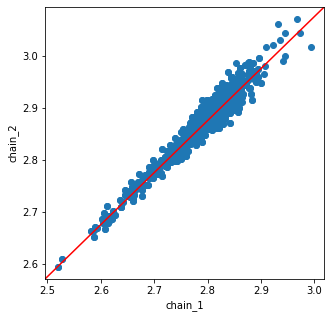

chain_1 chain_3 0.9160927009038788 0.054997608509809115


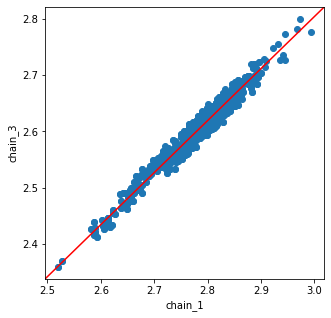

chain_1 chain_4 0.9190661764992405 -0.0016204902019239186


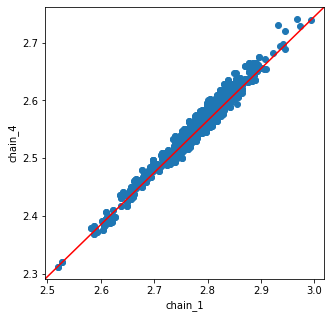

chain_1 chain_5 0.940386472953814 -0.07200475358588924


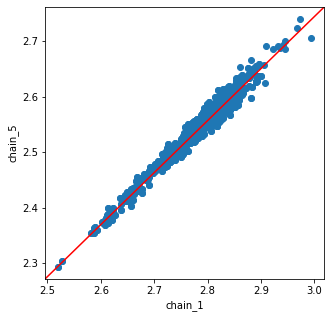

chain_2 chain_3 0.8714132240747117 0.10866030126955932


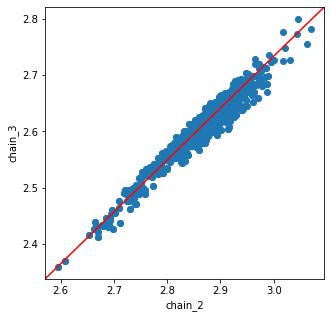

chain_2 chain_4 0.8803114964412375 0.034822417383392895


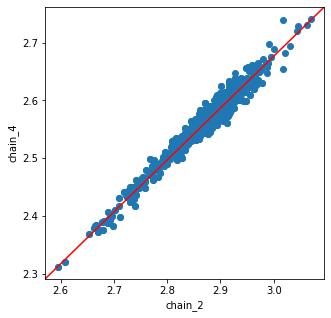

chain_2 chain_5 0.9023290901617332 -0.039290942660071215


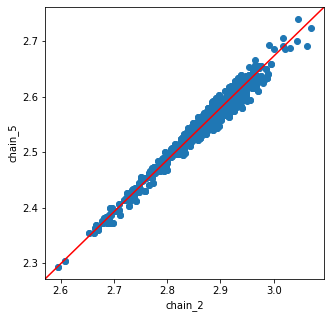

chain_3 chain_4 0.9872135077739986 -0.015019215538937723


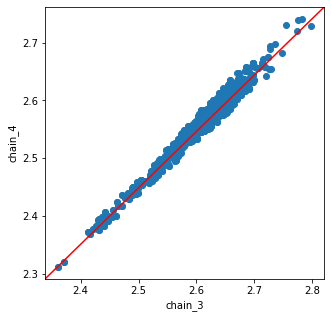

chain_3 chain_5 1.0090270088776352 -0.08288004310162504


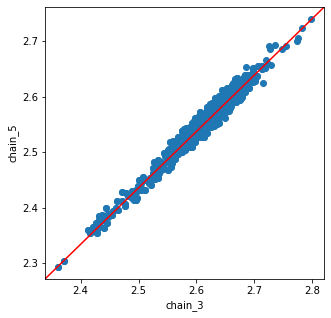

chain_4 chain_5 1.0033826540308766 -0.019669769491165383


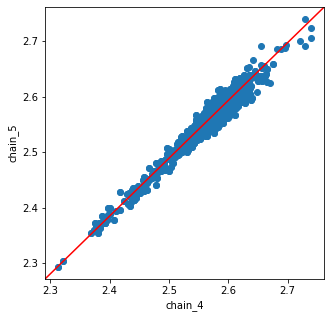

In [27]:
# plot pairwise chains agains 1:1 line, print slope and intercept from data

import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms

def abline(slope, intercept):
    """Plot a line from slope and intercept"""
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '--')

for i,chaini in enumerate(matrices):
    for j,chainj in enumerate(matrices):
        if i < j:
            slope, intercept = np.polyfit(matrices[chaini], matrices[chainj], 1)
            print(chaini, chainj, slope, intercept)
            fig, ax = plt.subplots(figsize=(5,5))
            ax.scatter(matrices[chaini], matrices[chainj])
            ax.set_xlabel(chaini)
            ax.set_ylabel(chainj)
            line = mlines.Line2D([0, 1], [0, 1], color='red')
            transform = ax.transAxes
            line.set_transform(transform)
            ax.add_line(line)           
            
            plt.show()

<a id='avg'></a>
#### estimate average covariance matrix

[top](#home)

In [28]:
# make a matrix with the average across matrices
mats = {}
for m in mfiles:
    chain = op.basename(m).split("_mat")[0]
    mats[chain] = pd.read_table(m, delim_whitespace=True, header=None)
mats[chain].head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37
0,2.593510,2.576068,2.590166,2.535881,2.526951,2.532791,2.507318,2.596089,2.560894,2.580293,2.542111,2.557782,2.586413,2.551922,2.377676,2.541271,2.552732,2.516945,2.427959,2.558492,2.503424,2.579618,2.521160,2.533229,2.559903,2.461964,2.539122,2.513789,2.545965,2.552274,2.538319,2.533114,2.601181,2.539887,2.535784,2.576481,2.527464,2.585766
1,2.576068,2.705714,2.618985,2.569317,2.582022,2.566618,2.547388,2.616444,2.596604,2.628136,2.603525,2.612867,2.638088,2.591115,2.426848,2.583137,2.593103,2.561234,2.466169,2.602207,2.553314,2.628880,2.560859,2.575949,2.609864,2.500408,2.579419,2.559637,2.592006,2.591599,2.578976,2.575209,2.637189,2.585016,2.579849,2.627117,2.570399,2.636387
2,2.590166,2.618985,2.684821,2.568861,2.569549,2.568504,2.556806,2.645842,2.609005,2.619700,2.583822,2.598552,2.627021,2.589443,2.424407,2.577907,2.587570,2.561318,2.469337,2.596603,2.542739,2.617021,2.558631,2.569579,2.601994,2.498896,2.581439,2.550646,2.585229,2.588019,2.575400,2.571407,2.638018,2.576443,2.573505,2.619238,2.565562,2.625285
3,2.535881,2.569317,2.568861,2.567846,2.518881,2.528968,2.490734,2.570150,2.548715,2.569423,2.537303,2.546029,2.582329,2.545869,2.363066,2.533952,2.545236,2.507412,2.417034,2.551794,2.498476,2.571569,2.508527,2.523041,2.553969,2.448901,2.531187,2.506266,2.537859,2.541050,2.529158,2.523276,2.594188,2.532452,2.528287,2.568481,2.516159,2.578596
4,2.526951,2.582022,2.569549,2.518881,2.573432,2.517774,2.497133,2.569166,2.550042,2.576179,2.549626,2.559259,2.584939,2.539449,2.371817,2.533974,2.545452,2.508109,2.418254,2.554423,2.498958,2.574361,2.509124,2.524930,2.556354,2.455554,2.533963,2.509086,2.540810,2.542914,2.525971,2.524911,2.588216,2.531811,2.527808,2.579114,2.518919,2.579758


In [29]:
# sum across each matrix (to use in average calc below)
for chain,m in mats.items():
    print(chain)
    if chain == 'chain_1':
        summatrix = np.array(m)
    else:
        summatrix = summatrix + np.array(m)
summatrix

chain_1
chain_2
chain_3
chain_4
chain_5


array([[13.616893, 13.537605, 13.585797, ..., 13.550847, 13.26361 ,
        13.568336],
       [13.537605, 14.233159, 13.756805, ..., 13.850669, 13.497843,
        13.848236],
       [13.585797, 13.756805, 14.059424, ..., 13.758935, 13.439045,
        13.761357],
       ...,
       [13.550847, 13.850669, 13.758935, ..., 14.167935, 13.519428,
        13.870569],
       [13.26361 , 13.497843, 13.439045, ..., 13.519428, 13.555172,
        13.561878],
       [13.568336, 13.848236, 13.761357, ..., 13.870569, 13.561878,
        14.283461]])

In [30]:
# calculate average netural matrix
avg = summatrix / len(mats)
avg.shape

(38, 38)

In [31]:
# convert to dataframe
avgmat = pd.DataFrame(avg)
print(avgmat.shape)
avgmat.head()

(38, 38)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37
0,2.723379,2.707521,2.717159,2.660911,2.658849,2.663706,2.635738,2.716546,2.700446,2.706382,2.664736,2.671942,2.702975,2.682434,2.501173,2.667623,2.677625,2.640830,2.554842,2.684453,2.627377,2.710740,2.651242,2.665154,2.680232,2.586964,2.660806,2.641013,2.671403,2.673116,2.665344,2.658767,2.725610,2.666727,2.667313,2.710169,2.652722,2.713667
1,2.707521,2.846632,2.751361,2.699021,2.720563,2.703018,2.682104,2.744017,2.743802,2.761378,2.734908,2.734086,2.760562,2.726418,2.555315,2.716617,2.726061,2.690974,2.597261,2.734104,2.683960,2.765840,2.697302,2.714055,2.732150,2.632998,2.708305,2.689955,2.720044,2.720270,2.712704,2.707658,2.768657,2.717300,2.719000,2.770134,2.699569,2.769647
2,2.717159,2.751361,2.811885,2.693036,2.702149,2.697607,2.684855,2.767025,2.746841,2.744803,2.706420,2.712479,2.744439,2.719580,2.546281,2.704433,2.712282,2.681908,2.593639,2.721310,2.666654,2.746437,2.686053,2.700633,2.719394,2.621719,2.701285,2.676323,2.707245,2.708277,2.701236,2.695123,2.760257,2.702549,2.704187,2.751787,2.687809,2.752271
3,2.660911,2.699021,2.693036,2.689842,2.647726,2.655625,2.617198,2.689239,2.686391,2.694748,2.658446,2.658804,2.696612,2.675105,2.485520,2.655982,2.664595,2.626937,2.540112,2.674333,2.618998,2.699209,2.637313,2.652682,2.669444,2.570914,2.651900,2.629376,2.660036,2.660825,2.654256,2.647158,2.714171,2.656942,2.656871,2.701585,2.638215,2.701346
4,2.658849,2.720563,2.702149,2.647726,2.710002,2.652142,2.630912,2.696053,2.694704,2.707424,2.677652,2.678326,2.706860,2.675107,2.502243,2.664431,2.674808,2.635397,2.548643,2.683257,2.627336,2.710014,2.644250,2.661218,2.679040,2.582986,2.659863,2.638762,2.669028,2.669013,2.658428,2.655703,2.715202,2.664237,2.665756,2.716308,2.648502,2.712882


<a id='compare'></a>
#### compare avg matrix to replicate matrices

[top](#home)

In [32]:
# make sure avgmat is highly correlated with other chains
avgmatlst = []
for row in avgmat.index:
    for col in avgmat.columns:
        avgmatlst.append(avgmat.loc[row, col])
print(len(avgmatlst), len(matrices[chain]))

for chain,lst in matrices.items():
    print(chain, pearsonr(matrices[chain], avgmatlst))

1444 1444
chain_1 (0.9922292771147385, 0.0)
chain_2 (0.9893153627407667, 0.0)
chain_3 (0.9923966631595194, 0.0)
chain_4 (0.9941021245585452, 0.0)
chain_5 (0.9938502348940706, 0.0)


In [33]:
baydir

'/data/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/coastal_variety_with-p6/03_maf-p05_RD-recalculated_FDC/baypass'

In [34]:
# save average matrix
omegafile = op.join(baydir, 'coastal_neutral_average_omegafile_noheaderidx.txt')
avgmat.to_csv(omegafile, sep='\t', index=False, header=False)

#### make sure pops are in same order as gfile

In [35]:
# load poolsize file
poolsizefile = pd.read_table(op.join(baydir, 'coastal_poolsizefile_HEADERIDX.txt'))
poolsizefile

,DF_p1,DF_p2,DF_p23,DF_p24,DF_p25,DF_p26,DF_p27,DF_p28,DF_p10,DF_p29,DF_p30,DF_p31,DF_p32,DF_p11,DF_p12,DF_p50,DF_p51,DF_p52,DF_p53,DF_p13,DF_p6,DF_p72,DF_p14,DF_p73,DF_p74,DF_p75,DF_p76,DF_p77,DF_p78,DF_p79,DF_p80,DF_p81,DF_p15,DF_p82,DF_p83,DF_p84,DF_p16,DF_p17
0,80,80,80,80,80,76,80,80,80,78,80,80,80,80,80,80,80,80,80,80,80,80,80,80,80,80,80,80,80,80,66,80,80,78,80,78,80,80


In [36]:
# compare to columns on gfile
gfile = pd.read_table(op.join(baydir, 'coastal_neutral_gfile_HEADERIDX.txt'), index_col=0)
gfilecols = [list(gfile.columns)[i].split("-")[0] for i in range(0,len(gfile.columns),2)]
pd.DataFrame(columns=gfilecols)  # just so it prints pretty

,DF_p1,DF_p2,DF_p23,DF_p24,DF_p25,DF_p26,DF_p27,DF_p28,DF_p10,DF_p29,DF_p30,DF_p31,DF_p32,DF_p11,DF_p12,DF_p50,DF_p51,DF_p52,DF_p53,DF_p13,DF_p6,DF_p72,DF_p14,DF_p73,DF_p74,DF_p75,DF_p76,DF_p77,DF_p78,DF_p79,DF_p80,DF_p81,DF_p15,DF_p82,DF_p83,DF_p84,DF_p16,DF_p17


In [37]:
# compare computationally
assert list(poolsizefile.columns) == gfilecols

In [38]:
# put columns on matrix for archiving
avgmat.columns = gfilecols
avgmat.index = gfilecols
avgmat.head()

,DF_p1,DF_p2,DF_p23,DF_p24,DF_p25,DF_p26,DF_p27,DF_p28,DF_p10,DF_p29,DF_p30,DF_p31,DF_p32,DF_p11,DF_p12,DF_p50,DF_p51,DF_p52,DF_p53,DF_p13,DF_p6,DF_p72,DF_p14,DF_p73,DF_p74,DF_p75,DF_p76,DF_p77,DF_p78,DF_p79,DF_p80,DF_p81,DF_p15,DF_p82,DF_p83,DF_p84,DF_p16,DF_p17
DF_p1,2.723379,2.707521,2.717159,2.660911,2.658849,2.663706,2.635738,2.716546,2.700446,2.706382,2.664736,2.671942,2.702975,2.682434,2.501173,2.667623,2.677625,2.640830,2.554842,2.684453,2.627377,2.710740,2.651242,2.665154,2.680232,2.586964,2.660806,2.641013,2.671403,2.673116,2.665344,2.658767,2.725610,2.666727,2.667313,2.710169,2.652722,2.713667
DF_p2,2.707521,2.846632,2.751361,2.699021,2.720563,2.703018,2.682104,2.744017,2.743802,2.761378,2.734908,2.734086,2.760562,2.726418,2.555315,2.716617,2.726061,2.690974,2.597261,2.734104,2.683960,2.765840,2.697302,2.714055,2.732150,2.632998,2.708305,2.689955,2.720044,2.720270,2.712704,2.707658,2.768657,2.717300,2.719000,2.770134,2.699569,2.769647
DF_p23,2.717159,2.751361,2.811885,2.693036,2.702149,2.697607,2.684855,2.767025,2.746841,2.744803,2.706420,2.712479,2.744439,2.719580,2.546281,2.704433,2.712282,2.681908,2.593639,2.721310,2.666654,2.746437,2.686053,2.700633,2.719394,2.621719,2.701285,2.676323,2.707245,2.708277,2.701236,2.695123,2.760257,2.702549,2.704187,2.751787,2.687809,2.752271
DF_p24,2.660911,2.699021,2.693036,2.689842,2.647726,2.655625,2.617198,2.689239,2.686391,2.694748,2.658446,2.658804,2.696612,2.675105,2.485520,2.655982,2.664595,2.626937,2.540112,2.674333,2.618998,2.699209,2.637313,2.652682,2.669444,2.570914,2.651900,2.629376,2.660036,2.660825,2.654256,2.647158,2.714171,2.656942,2.656871,2.701585,2.638215,2.701346
DF_p25,2.658849,2.720563,2.702149,2.647726,2.710002,2.652142,2.630912,2.696053,2.694704,2.707424,2.677652,2.678326,2.706860,2.675107,2.502243,2.664431,2.674808,2.635397,2.548643,2.683257,2.627336,2.710014,2.644250,2.661218,2.679040,2.582986,2.659863,2.638762,2.669028,2.669013,2.658428,2.655703,2.715202,2.664237,2.665756,2.716308,2.648502,2.712882


In [39]:
# save pop labels
avgmat.to_csv(op.join(baydir, 'coastal_neutral_average_omegafile_HEADERIDX.txt'), index=True, header=True, sep='\t')

<a id='geainfiles'></a>
# create infiles for baypass GEA

[top](#home)

<a id='efile'></a>
## make efile

[top](#home)

In [40]:
baydir

'/data/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/coastal_variety_with-p6/03_maf-p05_RD-recalculated_FDC/baypass'

In [41]:
poolsizefile

,DF_p1,DF_p2,DF_p23,DF_p24,DF_p25,DF_p26,DF_p27,DF_p28,DF_p10,DF_p29,DF_p30,DF_p31,DF_p32,DF_p11,DF_p12,DF_p50,DF_p51,DF_p52,DF_p53,DF_p13,DF_p6,DF_p72,DF_p14,DF_p73,DF_p74,DF_p75,DF_p76,DF_p77,DF_p78,DF_p79,DF_p80,DF_p81,DF_p15,DF_p82,DF_p83,DF_p84,DF_p16,DF_p17
0,80,80,80,80,80,76,80,80,80,78,80,80,80,80,80,80,80,80,80,80,80,80,80,80,80,80,80,80,80,80,66,80,80,78,80,78,80,80


In [42]:
ncol(poolsizefile)  # num pops

38

In [43]:
# load center/standardized environmental data
envdata = pd.read_table('/data/projects/pool_seq/environemental_data/change_p6/df_coastal-naturalpops_std_env-19variables_change-p6.txt')
envdata.index = envdata['our_id'].tolist()
envdata = envdata[envdata.index.isin(poolsizefile.columns)]
envdata.head()

,prov,our_id,Variety,LONG,LAT,Elevation,MAT,MWMT,MCMT,TD,MAP,MSP,AHM,SHM,DD_0,DD5,NFFD,bFFP,eFFP,FFP,PAS,EMT,EXT,Eref,CMD
DF_p1,1,DF_p1,FDC,-126.63,49.78,225,0.033205,-0.548835,0.543651,-0.997331,2.328792,2.609691,-1.091101,-0.811441,-0.545596,-0.324814,0.662851,-0.649675,0.433261,0.573164,0.004594,0.778311,-0.895826,-0.829706,-1.368839
DF_p2,2,DF_p2,FDC,-122.73,50.32,550,-1.041644,-0.199785,-1.629247,1.540520,-1.056228,-0.569995,0.536594,-0.106479,1.725063,-0.581350,-1.054536,0.324197,-1.278041,-0.779474,0.419775,-1.445170,-0.170729,-0.522306,0.134393
DF_p6,6,DF_p6,FDC,-125.75,52.28,460,-1.508969,-0.461573,-2.569755,2.352632,-1.286068,-0.828740,0.921322,0.090378,3.075349,-0.750289,-1.741491,1.005907,-2.163197,-1.580016,0.518853,-2.768670,-0.247055,-0.475906,0.564611
DF_p10,10,DF_p10,FDC,-125.33,50.00,152,-0.013528,-0.112523,0.089613,-0.185219,-0.518038,-0.133004,0.033488,-0.345900,-0.309447,-0.151704,0.388069,-0.600981,0.020188,0.352325,-0.533255,0.390084,-0.323381,-0.568706,-0.447666
DF_p11,11,DF_p11,FDC,-123.97,48.95,732,-1.181842,-1.072411,-0.559014,-0.252895,0.280713,-0.133004,-0.706373,-0.440339,0.623037,-1.244590,-0.527871,0.226810,-0.451895,-0.337796,1.443575,-0.245196,-1.201130,-1.276306,-0.665306


In [44]:
# check for 38 rows
envdata.shape

(38, 25)

In [45]:
# expecting 19 env variables
len(list(envdata.columns)[6:])

19

In [46]:
# triple check centered/standardized
for env in list(envdata.columns)[6:]:
    print(env, np.mean(envdata[env]), np.std(envdata[env]))

MAT 5.901711867744253e-16 1.0000000000000002
MWMT 2.973498640295403e-15 1.0
MCMT 1.460819769243627e-17 1.0
TD -9.051604495175824e-16 0.9999999999999998
MAP -1.2270886061646468e-16 0.9999999999999999
MSP -1.0371820361629752e-16 1.0000000000000002
AHM 9.933574430856664e-17 1.0
SHM 6.865852915445047e-17 1.0
DD_0 -8.764918615461762e-18 1.0000000000000002
DD5 5.40503314620142e-17 0.9999999999999999
NFFD -6.281525007747596e-17 0.9999999999999999
bFFP 2.9216395384872543e-16 1.0
eFFP 1.4527852605127872e-15 1.0
FFP 2.1181886654032592e-16 0.9999999999999998
PAS 4.8207052385039694e-17 1.0
EMT -1.7895042173234432e-16 1.0000000000000002
EXT -6.566384862750104e-16 0.9999999999999998
Eref -1.7566357725154614e-16 1.0
CMD -1.4316033738587545e-16 0.9999999999999998


In [47]:
# convert envdata to efile, making sure to order pops in same order as other files
efile = envdata.loc[poolsizefile.columns.tolist(), list(envdata.columns)[6:]]
efile.head()

,MAT,MWMT,MCMT,TD,MAP,MSP,AHM,SHM,DD_0,DD5,NFFD,bFFP,eFFP,FFP,PAS,EMT,EXT,Eref,CMD
DF_p1,0.033205,-0.548835,0.543651,-0.997331,2.328792,2.609691,-1.091101,-0.811441,-0.545596,-0.324814,0.662851,-0.649675,0.433261,0.573164,0.004594,0.778311,-0.895826,-0.829706,-1.368839
DF_p2,-1.041644,-0.199785,-1.629247,1.540520,-1.056228,-0.569995,0.536594,-0.106479,1.725063,-0.581350,-1.054536,0.324197,-1.278041,-0.779474,0.419775,-1.445170,-0.170729,-0.522306,0.134393
DF_p23,0.360333,-0.199785,0.770671,-0.963493,0.674399,0.700729,-0.661981,-0.589312,-0.703028,0.075633,1.120821,-1.282692,0.846333,1.125262,-0.585153,1.184185,-0.247055,-0.667306,-0.918375
DF_p24,-0.434121,-0.374310,-0.234700,-0.049867,1.916900,1.269968,-1.061506,-0.687740,-0.000637,-0.550065,-0.069901,-0.065352,-0.038823,0.021067,1.118035,0.019504,-0.552359,-0.754306,-1.085401
DF_p25,0.360333,0.062002,0.316632,-0.286733,0.644816,1.241219,-0.647184,-0.657148,-0.527430,0.211200,0.823141,-1.282692,0.728313,1.070052,-0.424742,0.584198,-0.208892,-0.591906,-1.176506


In [48]:
######################### VERY IMPORTANT!
# transpose df so pops are columns and env are rows
#########################
efile = efile.T
efile.head()

,DF_p1,DF_p2,DF_p23,DF_p24,DF_p25,DF_p26,DF_p27,DF_p28,DF_p10,DF_p29,DF_p30,DF_p31,DF_p32,DF_p11,DF_p12,DF_p50,DF_p51,DF_p52,DF_p53,DF_p13,DF_p6,DF_p72,DF_p14,DF_p73,DF_p74,DF_p75,DF_p76,DF_p77,DF_p78,DF_p79,DF_p80,DF_p81,DF_p15,DF_p82,DF_p83,DF_p84,DF_p16,DF_p17
MAT,0.033205,-1.041644,0.360333,-0.434121,0.360333,-0.013528,-1.041644,-0.527586,-0.013528,0.547263,-0.293923,0.079937,-1.275307,-1.181842,-1.742632,1.528646,1.201518,2.136169,0.407065,-1.135109,-1.508969,0.126670,1.341716,-1.041644,-0.901446,-1.695900,-1.415504,-0.621051,1.108053,1.622111,1.248251,0.827658,0.593995,0.500530,0.407065,0.407065,0.453798,0.593995
MWMT,-0.548835,-0.199785,-0.199785,-0.374310,0.062002,-0.112523,-1.421461,-1.116042,-0.112523,0.062002,0.803734,1.196415,-1.203304,-1.072411,-1.203304,1.981778,1.894515,2.636247,1.021890,-1.203304,-0.461573,0.803734,-0.025260,-0.810623,-0.810623,-0.985148,-1.159673,-0.897885,0.934628,1.109153,0.847365,-0.374310,-0.330679,-0.636098,0.062002,0.236527,0.105634,1.501834
MCMT,0.543651,-1.629247,0.770671,-0.234700,0.316632,0.251769,-0.429288,0.284201,0.089613,0.446357,-1.531953,-1.175209,-0.753601,-0.559014,-1.888698,1.062552,0.608514,1.289572,0.349063,-0.818464,-2.569755,-0.137406,1.711179,-0.429288,-0.559014,-1.596816,-0.915758,-0.299563,0.932827,1.484160,1.030121,1.257140,0.932827,0.965258,0.446357,0.154475,0.608514,-0.007681
TD,-0.997331,1.540520,-0.963493,-0.049867,-0.286733,-0.320571,-0.625113,-1.166521,-0.185219,-0.422085,2.217280,2.149604,-0.151381,-0.252895,1.032950,0.423865,0.829922,0.728407,0.457703,-0.117543,2.352632,0.762246,-1.809443,-0.185219,-0.049867,0.897598,0.017809,-0.354409,-0.286733,-0.692789,-0.388247,-1.572577,-1.200359,-1.538739,-0.455923,0.051647,-0.557437,1.168302
MAP,2.328792,-1.056228,0.674399,1.916900,0.644816,0.475280,1.084015,2.034096,-0.518038,-0.516900,-1.579626,-1.493152,1.008919,0.280713,0.155552,-0.681885,-1.237142,-0.357605,-0.978856,0.898550,-1.286068,-1.386196,-0.350778,-0.647750,-0.342814,-0.799080,0.330777,-0.078839,-0.409945,1.020297,-0.727398,0.620921,1.023710,1.033951,-0.397429,0.251129,0.311434,-1.248520


In [49]:
# save
efile.to_csv(op.join(baydir, 'coastal_efile_std_HEADERIDX.txt'), sep='\t', index=True, header=True)
efile.to_csv(op.join(baydir, 'coastal_efile_std_noheaderidx.txt'), sep='\t', index=False, header=False)

<a id='gfile'></a>
## create gfiles for GEA from "SNP" files (ADP < 1000)

[top](#home)

In [ ]:
# RESTART NOTEBOOK!!!

In [2]:
latest_commit()

##################################################################
Current commit of pythonimports:
commit 4937ed6baded6e6e058c905e26e9ae16bfe3f0d9
Author: Brandon <lindb@vcu.edu>
Date:   Tue Dec 1 11:28:39 2020 -0700
Today:	December 15, 2020 - 17:01:14
##################################################################



In [3]:
lview,dview = get_client()

56 56


In [7]:
linenums

{'/data/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/coastal_variety/03_maf-p05_RD-recalculated_FDC/DF_pooled-varscan_all_bedfiles_SNP_FDC_maf_RD-recalculated.txt': 2291591}

In [4]:
f = op.join(snpdir, 'DF_pooled-varscan_all_bedfiles_SNP_FDC_maf_RD-recalculated.txt')
snps = parallel_read(f,
                     lview=lview, dview=dview,
                     verbose=False)
print(snps.shape)
snps.index = snps['locus'].tolist()
snps.head()


Watching 56 parallel_read() jobs ...


DF_pooled-varscan_all_bedfiles_SNP_FDC_maf_RD-recalculated.txt: 100%|██████████| 56/56 [00:26<00:00,  2.10it/s]


(2254116, 319)


,CHROM,POS,REF,ALT,AF,QUAL,TYPE,FILTER,ADP,WT,HET,HOM,NC,DF_p1.GT,DF_p1.GQ,DF_p1.SDP,DF_p1.DP,DF_p1.FREQ,DF_p1.PVAL,DF_p1.AD,DF_p1.RD,DF_p2.GT,DF_p2.GQ,DF_p2.SDP,DF_p2.DP,DF_p2.FREQ,DF_p2.PVAL,DF_p2.AD,DF_p2.RD,DF_p23.GT,DF_p23.GQ,DF_p23.SDP,DF_p23.DP,DF_p23.FREQ,DF_p23.PVAL,DF_p23.AD,DF_p23.RD,DF_p24.GT,DF_p24.GQ,DF_p24.SDP,DF_p24.DP,DF_p24.FREQ,DF_p24.PVAL,DF_p24.AD,DF_p24.RD,DF_p25.GT,DF_p25.GQ,DF_p25.SDP,DF_p25.DP,DF_p25.FREQ,...,DF_p15.GT,DF_p15.GQ,DF_p15.SDP,DF_p15.DP,DF_p15.FREQ,DF_p15.PVAL,DF_p15.AD,DF_p15.RD,DF_p82.GT,DF_p82.GQ,DF_p82.SDP,DF_p82.DP,DF_p82.FREQ,DF_p82.PVAL,DF_p82.AD,DF_p82.RD,DF_p83.GT,DF_p83.GQ,DF_p83.SDP,DF_p83.DP,DF_p83.FREQ,DF_p83.PVAL,DF_p83.AD,DF_p83.RD,DF_p84.GT,DF_p84.GQ,DF_p84.SDP,DF_p84.DP,DF_p84.FREQ,DF_p84.PVAL,DF_p84.AD,DF_p84.RD,DF_p16.GT,DF_p16.GQ,DF_p16.SDP,DF_p16.DP,DF_p16.FREQ,DF_p16.PVAL,DF_p16.AD,DF_p16.RD,DF_p17.GT,DF_p17.GQ,DF_p17.SDP,DF_p17.DP,DF_p17.FREQ,DF_p17.PVAL,DF_p17.AD,DF_p17.RD,locus,MAF
jcf7190000000000-77738,jcf7190000000000,77738,T,C,0.677466,-10.0,SNP,PASS,13,2,49,28,8,T/C,49.0,17,17.0,70.59%,0.000011,12.0,5.0,./.,NaN,6,NaN,NaN,NaN,NaN,NaN,T/C,18.0,8,8.0,NaN,0.012821,5.0,3.0,T/C,32.0,11,11.0,72.73%,5.160000e-04,8.0,3.0,T/C,29.0,15,15.0,53.33%,...,T/C,23.0,9,9.0,66.67%,0.004525,6.0,3.0,T/C,30.0,14,14.0,57.14%,9.661800e-04,8.0,6.0,C/C,91.0,24,24.0,83.33%,6.349300e-10,20.0,4.0,C/C,36.0,9,9.0,88.89%,0.000206,8.0,1.0,T/C,21.0,12,12.0,50%,6.865000e-03,6.0,6.0,T/C,32.0,11,11.0,72.73%,0.000516,8.0,3.0,jcf7190000000000-77738,0.322534
jcf7190000000000-77764,jcf7190000000000,77764,T,C,0.765881,-10.0,SNP,PASS,12,1,28,50,8,T/C,50.0,16,16.0,75%,0.000008,12.0,4.0,./.,NaN,4,NaN,NaN,NaN,NaN,NaN,./.,NaN,6,NaN,NaN,NaN,NaN,NaN,C/C,49.0,13,13.0,84.62%,1.009600e-05,11.0,2.0,T/C,34.0,15,15.0,60%,...,T/C,18.0,8,8.0,NaN,0.012821,5.0,3.0,T/C,22.0,10,10.0,60%,5.418000e-03,6.0,4.0,C/C,84.0,21,21.0,85.71%,3.760300e-09,18.0,3.0,C/C,31.0,8,8.0,87.5%,0.000699,7.0,1.0,T/C,27.0,11,11.0,63.64%,1.935000e-03,7.0,4.0,C/C,44.0,12,12.0,83.33%,0.000034,10.0,2.0,jcf7190000000000-77764,0.234119
jcf7190000000004-54418,jcf7190000000004,54418,T,C,0.354288,-10.0,SNP,PASS,36,1,86,0,0,T/C,39.0,47,47.0,25.53%,0.000109,12.0,35.0,T/C,27.0,20,20.0,40%,0.001638,8.0,12.0,T/C,26.0,31,31.0,25.81%,0.002333,8.0,23.0,T/C,32.0,43,43.0,23.26%,5.414800e-04,10.0,33.0,T/C,47.0,42,42.0,33.33%,...,T/C,44.0,38,38.0,35.14%,0.000034,13.0,25.0,T/C,74.0,53,53.0,40.38%,3.757800e-08,21.0,32.0,T/C,95.0,54,54.0,48.15%,2.717100e-10,26.0,28.0,T/C,27.0,21,21.0,38.1%,0.001724,8.0,13.0,T/C,47.0,44,44.0,31.82%,1.787300e-05,14.0,30.0,T/T,9.0,14,14.0,NaN,0.111110,3.0,11.0,jcf7190000000004-54418,0.354288
jcf7190000000004-54508,jcf7190000000004,54508,A,G,0.077402,-10.0,SNP,PASS,53,67,20,0,0,A/A,89.0,65,65.0,4.62%,0.122090,3.0,62.0,A/A,40.0,32,32.0,6.25%,0.246030,2.0,30.0,A/G,22.0,44,44.0,15.91%,0.006036,7.0,37.0,A/G,21.0,65,65.0,10.77%,6.590400e-03,7.0,58.0,A/G,15.0,67,67.0,NaN,...,A/A,49.0,42,42.0,7.14%,0.120480,3.0,39.0,A/G,15.0,71,71.0,NaN,2.905800e-02,5.0,66.0,A/A,91.0,71,71.0,5.63%,5.985000e-02,4.0,67.0,A/A,41.0,27,27.0,3.7%,0.500000,1.0,26.0,A/A,93.0,67,67.0,4.48%,1.221800e-01,3.0,64.0,A/A,28.0,28,28.0,10.71%,0.118180,3.0,25.0,jcf7190000000004-54508,0.077402
jcf7190000000004-54540,jcf7190000000004,54540,A,G,0.346552,-10.0,SNP,PASS,56,1,58,28,0,A/G,56.0,67,67.0,25.37%,0.000002,17.0,50.0,A/G,37.0,36,36.0,30.56%,0.000199,11.0,25.0,A/G,18.0,47,47.0,NaN,0.013188,6.0,41.0,A/G,83.0,67,67.0,35.82%,4.810900e-09,24.0,43.0,A/G,86.0,70,70.0,35.71%,...,A/G,50.0,50,50.0,30%,0.000009,15.0,35.0,A/G,70.0,76,76.0,27.63%,9.593900e-08,21.0,55.0,A/G,122.0,77,77.0,44.16%,5.202800e-13,34.0,43.0,A/G,19.0,34,34.0,NaN,0.012287,6.0,28.0,A/G,75.0,67,67.0,32.84%,3.020700e-08,22.0,45.0,A/G,15.0,26,26.0,NaN,0.025310,5.0,21.0,jcf7190000000004-54540,0.346552


In [5]:
# reduce snps to those with ADP < 1000
reduced = snps[snps['ADP'] < 1000].copy()
reduced.shape, snps.shape

((2254011, 319), (2254116, 319))

In [6]:
# how many snps were dropped?
nrow(snps) - nrow(reduced)

105

In [1]:
# test function - ignore error I accidentally executed this cell
x = get_counts(reduced.index[:5], 38)
x.head()

NameError: name 'get_counts' is not defined

In [11]:
# get a list of cols necessary for get_counts() to save mem on engines
important_cols = [col for col in reduced.columns if '.FREQ' in col]
important_cols.extend([col for col in reduced.columns if 'AD' in col or 'RD' in col])
important_cols.extend(['AF', 'MAF'])
len(important_cols)

117

In [12]:
# restart engines
lview,dview = get_client()

15 15


In [13]:
reduced[important_cols].shape

(2254011, 117)

In [14]:
# load reduced to engines, but only important columns
dview['reduced'] = reduced[important_cols]

In [15]:
# thresh to evenly distribute jobs
thresh = math.ceil(nrow(reduced) / len(lview))
thresh

150268

In [16]:
# send jobs to engines for get_counts() to get a gfile for all SNPs
jobs = []
tosend = []
for i,locus in enumerate(reduced.index):
    tosend.append(locus)
    if len(tosend) == thresh or (i+1)==nrow(reduced):
        jobs.append(lview.apply_async(get_counts, *(tosend, 38)))
        tosend = []
watch_async(jobs)


Watching 15 jobs ...


100%|██████████| 15/15 [05:05<00:00, 20.36s/it]  


In [17]:
# get jobs returns
gfile = pd.concat([j.r for j in jobs])

In [18]:
# make sure returns make sense
assert nrow(reduced) == nrow(gfile)

In [19]:
# make sure returns make sense
assert nrow(reduced) == luni(gfile.index)

In [20]:
baydir

'/data/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/coastal_variety_with-p6/03_maf-p05_RD-recalculated_FDC/baypass'

In [21]:
def write_file(df, filepath):
    import pandas
    if 'noheader' in filepath:
        index=False
        header=False
    else:
        index = True
        header=True
    df.to_csv(filepath, sep='\t', header=header, index=index)
    return filepath

In [22]:
# write a file for use in baypass (no header/index) and one for us to use later to label loci (header/index = True)
jobs = []
files = [op.join(baydir, 'coastal_all_snps_ADP-lt-1000_gfile_HEADERIDX.txt'),
         op.join(baydir, 'coastal_all_snps_ADP-lt-1000_gfile_noheaderidx.txt')]
for f in nb(files):
    jobs.append(lview.apply_async(write_file, *(gfile, f)))
watch_async(jobs)

100%|██████████| 2/2 [00:03<00:00,  1.79s/it]



Watching 2 jobs ...


100%|██████████| 2/2 [00:23<00:00, 11.59s/it]


In [23]:
# load gfile with header/index
gfile = pd.read_table(op.join(baydir, 'coastal_all_snps_ADP-lt-1000_gfile_HEADERIDX.txt'), index_col=0)
gfile.head()

,DF_p1-major,DF_p1-minor,DF_p2-major,DF_p2-minor,DF_p23-major,DF_p23-minor,DF_p24-major,DF_p24-minor,DF_p25-major,DF_p25-minor,DF_p26-major,DF_p26-minor,DF_p27-major,DF_p27-minor,DF_p28-major,DF_p28-minor,DF_p10-major,DF_p10-minor,DF_p29-major,DF_p29-minor,DF_p30-major,DF_p30-minor,DF_p31-major,DF_p31-minor,DF_p32-major,DF_p32-minor,DF_p11-major,DF_p11-minor,DF_p12-major,DF_p12-minor,DF_p50-major,DF_p50-minor,DF_p51-major,DF_p51-minor,DF_p52-major,DF_p52-minor,DF_p53-major,DF_p53-minor,DF_p13-major,DF_p13-minor,DF_p6-major,DF_p6-minor,DF_p72-major,DF_p72-minor,DF_p14-major,DF_p14-minor,DF_p73-major,DF_p73-minor,DF_p74-major,DF_p74-minor,DF_p75-major,DF_p75-minor,DF_p76-major,DF_p76-minor,DF_p77-major,DF_p77-minor,DF_p78-major,DF_p78-minor,DF_p79-major,DF_p79-minor,DF_p80-major,DF_p80-minor,DF_p81-major,DF_p81-minor,DF_p15-major,DF_p15-minor,DF_p82-major,DF_p82-minor,DF_p83-major,DF_p83-minor,DF_p84-major,DF_p84-minor,DF_p16-major,DF_p16-minor,DF_p17-major,DF_p17-minor
jcf7190000000000-77738,12,5,0,0,0,0,8,3,8,7,7,3,8,7,0,0,8,7,10,12,11,7,7,6,7,4,11,1,10,2,0,0,0,0,20,3,12,2,9,7,0,0,23,1,10,4,12,1,8,9,0,0,6,10,9,6,12,2,0,0,9,9,9,4,6,3,8,6,20,4,8,1,6,6,8,3
jcf7190000000000-77764,12,4,0,0,0,0,11,2,9,6,8,1,6,7,9,0,10,5,15,7,10,4,10,4,9,3,11,1,12,1,7,4,0,0,23,0,9,0,8,6,0,0,21,2,11,3,14,1,6,7,13,3,8,7,12,4,15,1,0,0,10,3,9,4,0,0,6,4,18,3,7,1,7,4,10,2
jcf7190000000004-54418,35,12,12,8,23,8,33,10,28,14,28,13,25,11,24,15,27,10,29,14,28,11,18,15,22,20,21,19,21,21,28,10,29,7,23,17,0,0,30,12,19,9,36,18,13,14,21,12,0,0,26,10,31,11,24,13,33,24,24,18,35,15,26,13,25,13,32,21,28,26,13,8,30,14,0,0
jcf7190000000004-54508,62,3,30,2,37,7,58,7,0,0,51,0,49,3,35,2,0,0,0,0,52,4,44,1,46,3,58,3,66,0,48,10,43,11,65,0,50,0,56,1,41,1,0,0,35,14,43,11,32,1,55,10,65,2,66,2,0,0,52,4,73,2,46,12,39,3,0,0,67,4,26,1,64,3,25,3
jcf7190000000004-54540,50,17,25,11,0,0,43,24,45,25,31,24,38,18,29,9,39,17,49,21,37,21,21,23,37,10,41,22,50,19,35,15,40,10,35,33,23,31,35,17,27,26,53,20,40,17,51,16,24,16,32,37,46,22,40,32,50,26,37,25,58,18,38,16,35,15,55,21,43,34,0,0,45,22,0,0


In [24]:
baydir

'/data/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/coastal_variety_with-p6/03_maf-p05_RD-recalculated_FDC/baypass'

<a id='gparallel'></a>
### break up gfile for parallelization

[top](#home)

In [25]:
# create a directory to break up main gfile into tiny gfiles for parallel baypass calls
gfile_dir = makedir(op.join(baydir, 'individual_gfiles'))

In [27]:
# how many files if I split up main gfile into gfiles with 1500 SNPs each?
nrow(gfile)/1500

1502.674

In [29]:
# restart engines
lview,dview = get_client()

56 56


In [30]:
# write small gfiles to file
newjobs = []
tosend = []
jobcount = 0
for i,locus in enumerate(gfile.index):
    tosend.append(locus)
    if len(tosend) == 1500 or (i+1) == len(gfile.index):
        smallgfile = gfile.loc[tosend, :].copy()
        bname = 'coastal_all_snps_ADP-lt-1000_gfile_noheaderidx.txt'.replace('_gfile', '_gfile_%s' % str(jobcount).zfill(4))  # I changed this line
        smallpath = op.join(gfile_dir, bname)
        newjobs.append(lview.apply_async(write_file, *(smallgfile, smallpath)))
        pkldump(list(smallgfile.index), smallpath.replace(".txt", ".pkl"))  # save list of loci for later
        tosend = []
        jobcount += 1
watch_async(newjobs)


Watching 1503 jobs ...


100%|██████████| 1503/1503 [00:00<00:00, 211502.35it/s]


In [31]:
newjobs[0].r

'/data/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/coastal_variety_with-p6/03_maf-p05_RD-recalculated_FDC/baypass/individual_gfiles/coastal_all_snps_ADP-lt-1000_gfile_0000_noheaderidx.txt'

In [32]:
gfile_dir

'/data/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/coastal_variety_with-p6/03_maf-p05_RD-recalculated_FDC/baypass/individual_gfiles'

In [33]:
# make sure there are as many baypass gfiles as there are pkl files (pkl files contain row names aka loci names)
files = fs(gfile_dir, endswith='.txt')
pkls = fs(gfile_dir, endswith='.pkl')
assert len(files) == len(pkls) == len(newjobs)

In [34]:
len(files) , len(pkls)

(1503, 1503)

In [35]:
smallgfile.head()

,DF_p1-major,DF_p1-minor,DF_p2-major,DF_p2-minor,DF_p23-major,DF_p23-minor,DF_p24-major,DF_p24-minor,DF_p25-major,DF_p25-minor,DF_p26-major,DF_p26-minor,DF_p27-major,DF_p27-minor,DF_p28-major,DF_p28-minor,DF_p10-major,DF_p10-minor,DF_p29-major,DF_p29-minor,DF_p30-major,DF_p30-minor,DF_p31-major,DF_p31-minor,DF_p32-major,DF_p32-minor,DF_p11-major,DF_p11-minor,DF_p12-major,DF_p12-minor,DF_p50-major,DF_p50-minor,DF_p51-major,DF_p51-minor,DF_p52-major,DF_p52-minor,DF_p53-major,DF_p53-minor,DF_p13-major,DF_p13-minor,DF_p6-major,DF_p6-minor,DF_p72-major,DF_p72-minor,DF_p14-major,DF_p14-minor,DF_p73-major,DF_p73-minor,DF_p74-major,DF_p74-minor,DF_p75-major,DF_p75-minor,DF_p76-major,DF_p76-minor,DF_p77-major,DF_p77-minor,DF_p78-major,DF_p78-minor,DF_p79-major,DF_p79-minor,DF_p80-major,DF_p80-minor,DF_p81-major,DF_p81-minor,DF_p15-major,DF_p15-minor,DF_p82-major,DF_p82-minor,DF_p83-major,DF_p83-minor,DF_p84-major,DF_p84-minor,DF_p16-major,DF_p16-minor,DF_p17-major,DF_p17-minor
jcf7190016526376-2681,54,33,8,16,42,27,58,29,38,42,45,37,56,23,29,32,44,31,42,34,42,46,29,31,27,26,59,34,78,26,57,27,53,21,22,35,46,37,41,45,32,65,29,37,43,41,24,41,35,20,44,50,64,33,43,51,54,35,60,35,51,51,61,29,46,23,60,36,55,57,27,12,60,45,19,8
jcf7190016526376-2729,58,43,6,13,46,31,70,35,47,47,48,32,60,25,31,36,44,31,44,32,49,57,29,32,28,32,54,30,84,24,51,32,51,22,24,40,46,49,49,40,37,65,35,34,47,38,30,43,35,24,42,59,64,34,43,56,66,33,62,44,61,61,63,33,41,25,59,36,60,56,29,14,62,42,10,9
jcf7190016526376-2764,63,42,0,0,44,30,82,32,60,47,49,29,57,27,31,39,46,27,43,29,55,54,30,25,36,30,54,26,93,28,48,32,55,15,26,47,50,46,51,37,38,67,36,33,48,39,36,50,34,28,57,44,65,39,49,55,72,39,65,38,61,57,65,34,37,25,57,39,63,53,31,13,61,47,14,6
jcf7190016526376-3182,67,36,0,0,43,39,88,34,36,48,47,36,68,33,45,38,60,37,44,27,34,60,32,38,40,30,50,32,83,18,69,32,54,12,21,38,60,44,59,40,43,55,50,42,54,35,23,42,24,25,55,62,70,34,65,85,72,45,49,41,76,79,70,37,31,21,69,42,61,53,26,24,65,69,16,12
jcf7190016526376-3271,71,38,0,0,49,34,95,28,49,51,57,26,76,34,41,32,70,38,47,32,52,59,51,33,34,32,60,29,91,27,62,27,49,15,29,48,70,54,55,44,48,56,51,33,53,43,34,49,20,26,67,49,70,40,71,86,72,53,59,51,96,83,78,42,32,19,69,48,53,48,18,19,77,71,15,13


In [37]:
# triple check missing data < 25%
majorcols = [col for col in smallgfile if 'major' in col]
for locus in nb(smallgfile.index):
    missingcount = 0
    for col in majorcols:
        if smallgfile.loc[locus, col] == 0 and smallgfile.loc[locus, col.replace("-major", "-minor")] == 0:
            missingcount += 1
    if missingcount/len(majorcols) > 0.25:
        print(locus)
        break
missingcount/len(majorcols)

100%|██████████| 1011/1011 [00:00<00:00, 3347.18it/s]


0.18421052631578946

<a id='commands'></a>
# create commands to run baypass GEA using gfiles from above

[top](#home)

In [38]:
gfile_dir

'/data/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/coastal_variety_with-p6/03_maf-p05_RD-recalculated_FDC/baypass/individual_gfiles'

In [39]:
# get gfiles
gfiles = fs(gfile_dir, pattern='noheader', endswith='.txt')
len(gfiles)

1503

In [40]:
# get efile
efile = op.join(baydir, 'coastal_efile_std_noheaderidx.txt')
assert op.exists(efile)

In [41]:
# get omegafile and poolsize file
omegafile = op.join(baydir, 'coastal_neutral_average_omegafile_noheaderidx.txt')
poolsizefile = op.join(baydir, 'coastal_poolsizefile_noheaderidx.txt')
assert all([op.exists(omegafile), op.exists(poolsizefile)])

In [42]:
cmddir = makedir(op.join(baydir, 'cmd_files'))
cmddir

'/data/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/coastal_variety_with-p6/03_maf-p05_RD-recalculated_FDC/baypass/cmd_files'

#### as a rule of thumb, d0yij can be set to 1/5th the minimum pool size

In [43]:
# set compute canada dirs
cbay = '/scratch/lindb/coastal_baypass'
ccmddir = op.join(cbay, 'cmd_files')
cres = op.join(ccmddir, 'results')
csh = op.join(ccmddir, 'shfiles')
for d in [ccmddir, cres, csh]:
    print('mkdir ', d)

mkdir  /scratch/lindb/coastal_baypass/cmd_files
mkdir  /scratch/lindb/coastal_baypass/cmd_files/results
mkdir  /scratch/lindb/coastal_baypass/cmd_files/shfiles


In [45]:
# create baypass commands for each gfile for 5 chains each
cmds = []
for gfile in nb(gfiles):
    for chain in ['chain_1', 'chain_2', 'chain_3', 'chain_4', 'chain_5']:
        seed = random.randint(1, 100000)
        bname = op.basename(gfile).split("_noheader")[0]
        outprefix = f"{bname}_{chain}"
        cmd = f'i_baypass -gfile {gfile.replace(baydir, cbay)} \
-efile {efile.replace(baydir, cbay)} \
-omegafile {omegafile.replace(baydir, cbay)} \
-poolsizefile {poolsizefile.replace(baydir, cbay)} \
-outprefix {outprefix} \
-d0yij 8 \
-seed {seed} \
-pilotlength 1000 \
-nval 50000 \
-npilot 40 '
        cmds.append(cmd)
len(cmds)

100%|██████████| 1503/1503 [00:00<00:00, 29189.55it/s]


7515

In [46]:
cmds[0].split()

['i_baypass',
 '-gfile',
 '/scratch/lindb/coastal_baypass/individual_gfiles/coastal_all_snps_ADP-lt-1000_gfile_0000_noheaderidx.txt',
 '-efile',
 '/scratch/lindb/coastal_baypass/coastal_efile_std_noheaderidx.txt',
 '-omegafile',
 '/scratch/lindb/coastal_baypass/coastal_neutral_average_omegafile_noheaderidx.txt',
 '-poolsizefile',
 '/scratch/lindb/coastal_baypass/coastal_poolsizefile_noheaderidx.txt',
 '-outprefix',
 'coastal_all_snps_ADP-lt-1000_gfile_0000_chain_1',
 '-d0yij',
 '8',
 '-seed',
 '97514',
 '-pilotlength',
 '1000',
 '-nval',
 '50000',
 '-npilot',
 '40']

<a id='catfiles'></a>
### create catfiles to hold commands

[top](#home)

In [48]:
# create catfiles for baypass commands - for requests of a single node with 48 CPUs
rundir = makedir(op.join(cmddir, 'run_01'))
catfiles = []
tocat = []
for i,cmd in enumerate(nb(cmds)):
    tocat.append(cmd)
    if len(tocat) == 48 or (i+1) == len(cmds):
        file = op.join(rundir, 'catfile_%s.txt' % str(len(catfiles)).zfill(4))
        with open(file, 'w') as o:
            o.write('\n'.join(tocat))
        tocat = []
        catfiles.append(file)
len(catfiles)

100%|██████████| 7515/7515 [00:00<00:00, 89735.16it/s]


157

<a id='geashfiles'></a>
### create slurm shfiles for executing commands in parallel

[top](#home)

In [49]:
# create slurm jobs, cat catfiles at GNU parallel
resdir = makedir(op.join(cmddir, 'results'))
shdir = makedir(op.join(cmddir, 'shfiles'))
shfiles = []
for catfile in nb(catfiles):
    num = catfile.split("_")[-1].split(".")[0]
    shfile = op.join(shdir, op.basename(f"batch_{num}.sh"))
    with open(shfile, 'w') as o:
        text = f'''#!/bin/bash
#SBATCH --job-name=batch_{num}
#SBATCH --time=3-00:00:00
#SBATCH --nodes=1
#SBATCH --ntasks=1
#SBATCH --mem-per-cpu=25
#SBATCH --cpus-per-task=48
#SBATCH --output=batch_{num}_%j.out
#SBATCH --mail-user=lindb@vcu.edu
#SBATCH --mail-type=FAIL

export PATH="${{PATH}}:/project/def-saitken/programs/baypass_2.2/sources"

cd {cres}

cat {catfile.replace(cmddir, ccmddir)} | parallel -j 48 --progress

source $HOME/py3/bin/activate
cd $HOME/pipeline
python balance_queue.py lindb /home/lindb

'''
        o.write("%s" % text)
    shfiles.append(shfile)
len(shfiles)

100%|██████████| 157/157 [00:00<00:00, 3638.52it/s]


157

<a id='transfer'></a>
# transfer to cedar, graham, beluga, and arc

[top](#home)

In [50]:
baydir

'/data/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/coastal_variety_with-p6/03_maf-p05_RD-recalculated_FDC/baypass'

In [51]:
# get infiles
files = [efile, omegafile]
files.extend(fs(baydir, 'nohead', exclude=['all_snps', 'neutral_gfile']))
files

['/data/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/coastal_variety_with-p6/03_maf-p05_RD-recalculated_FDC/baypass/coastal_efile_std_noheaderidx.txt',
 '/data/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/coastal_variety_with-p6/03_maf-p05_RD-recalculated_FDC/baypass/coastal_neutral_average_omegafile_noheaderidx.txt',
 '/data/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/coastal_variety_with-p6/03_maf-p05_RD-recalculated_FDC/baypass/coastal_efile_std_noheaderidx.txt',
 '/data/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/coastal_variety_with-p6/03_maf-p05_RD-recalculated_FDC/baypass/coastal_neutral_average_omegafile_noheaderidx.txt',
 '/data/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/coastal_variety_with-p6/03_maf-p05_RD-recalculated_FDC/baypass/coastal_poolsizefile_noheaderidx.txt']

In [52]:
# get gfiles
gfiles = fs(gfile_dir, exclude='.pkl')
files.extend(gfiles)
len(files)

1508

In [53]:
rundir

'/data/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/coastal_variety_with-p6/03_maf-p05_RD-recalculated_FDC/baypass/cmd_files/run_01'

In [54]:
shdir

'/data/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/coastal_variety_with-p6/03_maf-p05_RD-recalculated_FDC/baypass/cmd_files/shfiles'

In [55]:
# get catfiles and shfiles
files.extend(fs(shdir, endswith='.sh'))
files.extend(fs(rundir, endswith='.txt'))
len(files)

1822

In [56]:
files[0]

'/data/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/coastal_variety_with-p6/03_maf-p05_RD-recalculated_FDC/baypass/coastal_efile_std_noheaderidx.txt'

In [57]:
cbay

'/scratch/lindb/coastal_baypass'

In [58]:
dirs = []
for f in files:
    d = op.dirname(f)
    if d not in dirs:
        dirs.append(d)
sorted(dirs)

['/data/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/coastal_variety_with-p6/03_maf-p05_RD-recalculated_FDC/baypass',
 '/data/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/coastal_variety_with-p6/03_maf-p05_RD-recalculated_FDC/baypass/cmd_files/run_01',
 '/data/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/coastal_variety_with-p6/03_maf-p05_RD-recalculated_FDC/baypass/cmd_files/shfiles',
 '/data/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/coastal_variety_with-p6/03_maf-p05_RD-recalculated_FDC/baypass/individual_gfiles']

In [3]:
# transfer in parallel
jobs = []
# for src in files:
for src in fs(rundir, endswith='.txt'):
    dstdir = 'cedar:' + op.dirname(src).replace(baydir, cbay)
    jobs.append(lview.apply_async(rsync, *(src,dstdir)))
watch_async(jobs)

NameError: name 'fs' is not defined

In [86]:
# see if any failed (repeat cell until all worked)
needed = []
for i,j in enumerate(jobs):
    if j.ready():
        try:
            if not 'speedup' in '\n'.join(j.r):
                needed.append(files[i])
        except:
            needed.append(files[i])
print(len(needed))
jobs = []
for src in needed:
    dstdir = 'cedar:' + op.dirname(src).replace(baydir, cbay)
    jobs.append(lview.apply_async(rsync, *(src,dstdir)))
watch_async(jobs)


Watching 1822 jobs ...


100%|██████████| 1822/1822 [01:11<00:00, 25.59it/s]


In [88]:
# see if any failed (repeat cell until all worked)
needed = []
for i,j in enumerate(jobs):
    if j.ready():
        try:
            if not 'speedup' in '\n'.join(j.r):
                needed.append(files[i])
        except:
            needed.append(files[i])
print(len(needed))
jobs = []
for src in needed:
    dstdir = 'cedar:' + op.dirname(src).replace(baydir, cbay)
    jobs.append(lview.apply_async(rsync, *(src,dstdir)))
watch_async(jobs)

0

Watching 0 jobs ...


0it [00:00, ?it/s]


[top](#home)